<a href="https://colab.research.google.com/github/lfernandof/lfp_signals_analysis/blob/main/consistency_check_LFP_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and installs

In [1]:
# IMPORTS AND INSTALLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import json
import scipy
import pickle
import seaborn as sns


# ACCESS TO DATA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convert data from .mat into .csv and .npy files

In [ ]:
#should run at 'all_channels' folder

def data_from_mat(rat_id,day_id):

    animal_label = f'rat{rat_id}_day{day_id}_LFP_all'
    data = sio.loadmat('./data/'+animal_label+'_regions.mat')

    lfp = data[animal_label]['data'][0][0].T #using the transpose so its shape is (num_channels,num_points)
    timestamps = data[animal_label]['timestamps'][0][0]
    regions_listing = data[animal_label]['regions'][0][0][0]

    regions = {}
    metadata = {}
    metadata['total_duration'] = data[animal_label]['duration'][0][0][0][0]
    metadata['interval'] = data[animal_label]['interval'][0][0][0]
    metadata['sampling_rate'] = data[animal_label]['samplingRate'][0][0][0][0]

    #create a folder to store the data
    os.chdir('./data/separated_channels')
    os.makedirs(animal_label)

    #go inside this folder
    os.chdir(animal_label)

    #loop through the dataset
    for i in range(np.shape(lfp)[0]):
        label = f'ch{i}_{regions_listing[i][0]}'  #chX_region, channel in [0,31]
        #and region being either "PFC" or "STR"

        regions[label.split('_')[0]] = label.split('_')[1]

        #save each channel's activity as a .npy file
        np.save(file=label,arr=lfp[i,:])

    #save the timestamps to a .npy file
    np.save(file='timestamps',arr=timestamps)

    #save the channel-region correspondence into a file
    import json
    with open("channel_region", "w") as regions_file:
        json.dump(obj=regions,fp=regions_file)

#    with open('channel_region.txt','w') as regions_file:
#        regions_file.write(str(regions))

    #save the metadata to a text file
    with open('metadata.json','w') as metadata_file:
        metadata_file.write(str(metadata))

    #return to the former directory
    os.chdir('../../..')
    #and confirm whether it really is where one started
    print(os.getcwd())

In [ ]:
######## USE THIS ONE

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

#load auxiliary session data (trial segmenting times for all animals)
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

data_from_mat(rat_id=6,day_id=2)

KeyboardInterrupt: 

# Utilitary functions

In [2]:
#this should be run inside all_channels/data/separated_channels/______ (session)
def comodulogram_gif(trials_dict,ind_band=[1,20],dep_band=[30,200],ind_step=0.25,dep_step=2,ind_bandwidth=0.25,dep_bandwidth=2,
                     nbins=50,sampling_rate=1250):
#  lfp,ind_band=[1,20],dep_band=[20,200],ind_step=0.25,dep_step=2,
#                  ind_bandwidth=0.25,dep_bandwidth=2,num_bins=50,sampling_rate=1250
    os.mkdir('./comodulogram_gif')
    #generate each trial's comodulogram and save it to a .png file
    for trial_index in trials_dict.keys():
        current_lfp = trials_dict[trial_index].lfp.values
        comod, ind_freqs, dep_freqs = comodulogram2(current_lfp,ind_band=[1,20],dep_band=[25,200],ind_step=2,
                                                dep_step=5,ind_bandwidth=5,dep_bandwidth=10,
                                                num_bins=18,sampling_rate=1250)
        plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index) #WRITE THIS FUNCTION HERE
        plt.savefig('./comodulogram_gif/'+trial_index+'.png',format='png')
        plt.close()

    #make a gif out of these images
    filenames = ['./comodulogram_gif/'+trial_index+'.png' for trial_index in trials_dict.keys()]
    import imageio as iio
    images = list()

    for file in filenames:
        images.append(iio.imread(file))

    iio.mimsave('./session_cfc.gif',images,format='GIF',duration=0.4)

##################################################################################

def compute_erp(trials_dict,norm_by_mean = True):
    #I should use the number of points in the shortest trial in the dictionary
    #for now, I will choose a random trial from the dictionary because all should have the same length
    from numpy import random
    series_length = len(trials_dict[random.choice(list(trials_dict.keys()))])

    num_trials = len(trials_dict)
    recipient = np.ndarray([num_trials,series_length])
    counter = 0
    for trial in trials_dict.keys():
        buffer_lfp = trials_dict[trial]['lfp']
        if norm_by_mean:
            buffer_lfp = buffer_lfp - np.mean(buffer_lfp)
        recipient[counter,:] = buffer_lfp
        counter+=1

    #the "ERP" is the mean along all trials
    erp = np.mean(recipient,axis=0)
    return erp,recipient

def erp_comodulogram(erp_signal,erp_label):
    comod,ind_freqs,dep_freqs = comodulogram2(erp_signal,ind_band=[1,20],dep_band=[20,200],ind_step=2,dep_step=5,
                                ind_bandwidth=4,dep_bandwidth=10,num_bins=18,sampling_rate=1250)
    plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index='')
    plt.savefig('./erp_comodulogram/'+erp_label+'.png',format='png')

    plt.close()

In [3]:
# This should be run inside all_channels/data/separated_channels/______ (session)
def load_lfp(rat_id,day_id,channel_id):
  #new version, using regular expressions to identify the channel file and the region substring from this filename
  import re
  def find_channel_file_regex(channel_number):
      if 0 <= channel_number <= 32:
          return re.compile(r'ch{}_'.format(channel_number) + r'(?:PFC|STR)')
      else:
          raise ValueError("Channel number must be between 0 and 32")

  channel_regex = find_channel_file_regex(channel_id)

  matches = [s for s in os.listdir(f'.') if channel_regex.match(s)][0]

  def find_region_substring_between_markers(text, start_marker='_', end_marker='.'):
    pattern = f"{re.escape(start_marker)}(.*?){re.escape(end_marker)}"
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # This captures the target substring
    return None

  region = find_region_substring_between_markers(matches)

  timestamps_data = np.squeeze(np.load(f'./timestamps.npy'))
  lfp_data = np.squeeze(np.load(f'./ch{channel_id}_'+region+'.npy'))

  df = pd.DataFrame.from_dict({'timestamps':timestamps_data,'lfp':lfp_data})
  return df,channel_id,region

In [4]:
# This should be run inside all_channels/data/separated_channels/______ (session)
def comodulogram_per_trial(trials_dict,ind_band=[1,20],dep_band=[20,200],ind_step=0.25,dep_step=2,
                  ind_bandwidth=0.25,dep_bandwidth=2,num_bins=50,sampling_rate=1250):
    '''
    Estimate the comodulogram using data from each trial. Save the plots separately indicating which trial it belongs to and the comodulograms themselves in a dictionary.
    '''

    try:
      os.mkdir('./individual_trial_comodulograms')
    except:
      print('individual_trial_comodulograms folder already exists')

    comodulograms_dict = {}

    # Generate each trial's comodulogram and save it to a .png file
    for trial_index in trials_dict.keys():
        print(trial_index)
        current_lfp = trials_dict[trial_index].lfp.values
        comod, ind_freqs, dep_freqs = comodulogram2(current_lfp,ind_band,dep_band,ind_step,
                                                dep_step,ind_bandwidth,dep_bandwidth,
                                                num_bins,sampling_rate)

        #plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index) #WRITE THIS FUNCTION HERE
        #plt.savefig('./individual_trial_comodulograms/'+trial_index+'.png',format='png')
        #plt.close()

        # Save all comodulograms into a dictionary
        comodulograms_dict[trial_index] = comod

    # Also save the independent and dependent frequencies for later use (e.g. plotting one of them again)
    comodulograms_dict['ind_freqs'] = ind_freqs
    comodulograms_dict['dep_freqs'] = dep_freqs

    #with open('./individual_trial_comodulograms/comodulograms_dict.pkl', 'wb') as f:
    #  pickle.dump(comodulograms_dict, f)
    return comodulograms_dict

def compute_erp(trials_dict,norm_by_mean = True):
    #I should use the number of points in the shortest trial in the dictionary
    #for now, I will choose a random trial from the dictionary because all should have the same length
    from numpy import random
    series_length = len(trials_dict[random.choice(list(trials_dict.keys()))])

    num_trials = len(trials_dict)
    recipient = np.ndarray([num_trials,series_length])
    counter = 0
    for trial in trials_dict.keys():
        buffer_lfp = trials_dict[trial]['lfp']
        if norm_by_mean:
            buffer_lfp = buffer_lfp - np.mean(buffer_lfp)
        recipient[counter,:] = buffer_lfp
        counter+=1

    #the "ERP" is the mean along all trials
    erp = np.mean(recipient,axis=0)
    return erp,recipient

def erp_comodulogram(erp_signal,erp_label):
    comod,ind_freqs,dep_freqs = comodulogram2(erp_signal,ind_band=[1,20],dep_band=[20,200],ind_step=2,dep_step=5,
                                ind_bandwidth=4,dep_bandwidth=10,num_bins=18,sampling_rate=1250)
    plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index='')
    plt.savefig('./erp_comodulogram/'+erp_label+'.png',format='png')

    plt.close()

In [5]:
def split_lfp_trials(session_df,lfp_df,rat_id,day_id,region_id,min_duration=0.8,sampling_rate=1250,
                      slicing='first',peri_trial_inclusion = 0,per_slice=1500):
    elegible_trials = session_df.query(f"rat == {rat_id} & day == {day_id} &\
    region == '{region_id}' & duration >= {min_duration}")
    elegible_trials = elegible_trials.sort_values('trial').copy()

    #separate the lfp df into a dictionary of trials, whose keys are trial identifiers and
    #values are dfs corresponding to excerpts of the whole lfp signal that fall between
    #each trials' time boundaries [trial begin, trial end]

    trials_dict = {}
    for trial in elegible_trials.trial.unique():
        '''upon profiling this function to probe its performance I have concluded it is very slow
        the pieces of code that were taking too long were these queries below, so I'll comment them out and implement another querying method (expression matching on Series.values)
        nonetheless, I will leave them for the sake of comprehension of what is going on in the following expression, which yields the same but in a fraction of the elapsed time
        '''

        #select the current trial in the behavioral/spikes dataframe
        #current_trial = elegible_trials.query(f"trial == {int(trial)}")
        current_trial = elegible_trials[elegible_trials.trial.values == int(trial)]

        #extract the timestamps for the beginning and end of trial using the 1st
        #spike (begin) and total duration (end)
        begin = current_trial.iloc[0].timestamp - current_trial.iloc[0].time
        end = begin + current_trial.iloc[0].duration

        #fetch the lfp data within these two timepoints and add to the dict as our trial
        #current_lfp = lfp_df.query(f"timestamps >= {begin-peri_trial_inclusion} & timestamps <= {end}")
        current_lfp = lfp_df[(lfp_df.timestamps.values >= (begin-peri_trial_inclusion)) & (lfp_df.timestamps.values <= end)]

        if slicing == 'first':
                trials_dict[f'trial_{int(trial)}'] = current_lfp.head(per_slice)
        elif slicing == 'last':
            trials_dict[f'trial_{int(trial)}'] = current_lfp.tail(per_slice)
        elif slicing == 'none':
            trials_dict[f'trial_{int(trial)}'] = current_lfp
    print('done parsing the LFP into trials')

    return trials_dict

#new version: soon i'll simply delete the other implementation of these two above

def comodulogram2(lfp,ind_band=[1,20],dep_band=[20,200],ind_step=0.25,dep_step=2,
                  ind_bandwidth=0.25,dep_bandwidth=2,num_bins=50,sampling_rate=1250,verbosity=False):
  '''
  estimate the modulation index for pairs of frequencies {modulating,modulated}, each spanning a range of values
  '''

  freqs_for_amps = np.arange(dep_band[0],dep_band[1]+dep_step,dep_step)
  freqs_for_phases = np.arange(ind_band[0],ind_band[1]+ind_step,ind_step)

  filtered_phases = np.empty([len(freqs_for_phases) - 1,len(lfp)])

  from scipy.signal import hilbert

  for phase_index,phase in enumerate(freqs_for_phases[0:-1]):
    filtered_phases[phase_index,:] = np.angle(hilbert(band_extraction(lfp,cutoff_low=freqs_for_phases[phase_index],cutoff_high=freqs_for_phases[phase_index+1],
                                              sampling_rate=sampling_rate)))

  comod = np.zeros([len(freqs_for_amps) - 1, len(freqs_for_phases)])

  phasebins = np.linspace(-np.pi,np.pi,num_bins+1)
  phasecenters = phasebins[0:-1] + (phasebins[1] - phasebins[0])

  #iterate over signals filtered at higher frequencies (each band for which we extract the amplitude envelope)
  for amp_index,current_amp in enumerate(freqs_for_amps[:-1]):
    if verbosity:
      print(f'Progress: [{amp_index+1}/{len(freqs_for_amps)-1}]')

    amp_envelope = abs(hilbert(band_extraction(lfp,cutoff_low=freqs_for_amps[amp_index],cutoff_high=freqs_for_amps[amp_index+1],
                                                      sampling_rate=sampling_rate)))

    '''
    to exploit the storage vs. processing conundrum, I have already filtered the signal in each low-frequency band of interest
    and put each band's signal in a vector (filtered_phases, 76 bands in total).
    once again I have opted for such an approach and below I create a vector called bins_freq,
    that will store each frequency bin's (from [-pi,pi]) mean amplitude in a single modulated band (from which we extract the amplitude envelope)
    '''

    bins_freq = np.empty((num_bins,len(filtered_phases)))

    for phase_bin_id in range(len(phasebins)-1):
      #print(phase_bin_id)
      #print(phasebins[phase_bin_id],phasebins[phase_bin_id+1])

      for band_id,band_signal in enumerate(filtered_phases):
        phasepoints_in_frequency_bin = np.where((band_signal > phasebins[phase_bin_id]) & (band_signal < phasebins[phase_bin_id+1]))[0]
        mean_amplitude_in_frequency_bin = np.mean(amp_envelope[phasepoints_in_frequency_bin])
        #print(mean_amplitude_in_frequency_bin)
        bins_freq[phase_bin_id,band_id] = mean_amplitude_in_frequency_bin

      #print(f'estimated mean amplitude in bin {phase_bin_id} [{phasebins[phase_bin_id]} Hz, {phasebins[phase_bin_id+1]} Hz] in all modulating bands!')
      #print(sum(bins_freq[:,band_id]))
    if verbosity:
      print(f'finished all frequency bins for all modulating bands in this modulated band: [{freqs_for_amps[amp_index]} Hz,{freqs_for_amps[amp_index+1]} Hz]')
    #normalize over each phase bin, yielding what is dubbed p
    p = [bins_freq[:,band_id]/sum(bins_freq[:,band_id]) for band_id in range(len(filtered_phases))]

    #estimate MI
    from scipy.stats import entropy
    uniform_dist = np.ones(num_bins)/num_bins

    #iterating over all low-frequency filtered bands:
    for low_freq_band_index in range(np.shape(p)[0]):
      MI = entropy(p[low_freq_band_index],uniform_dist)/np.log(num_bins)
      comod[amp_index,low_freq_band_index] = MI

  return comod,freqs_for_phases,freqs_for_amps

def plot_comodulogram(comod,ind_freqs,dep_freqs,trial_index=''):
    #make a grid to accommodate the data
    x,y = np.meshgrid(ind_freqs,dep_freqs[:-1])

    plt.contourf(x, y, comod, 30, cmap=plt.cm.viridis)
    plt.title(f'Trial: {trial_index}')
    plt.xlabel('Independent \n frequency (Hz)',size=13)
    plt.ylabel('Dependent \n frequency (Hz)',size=13)
    plt.colorbar(label="Modulation Index (MI)")

def band_extraction(lfp_data,cutoff_low,cutoff_high,sampling_rate=1250,order=3):
    '''Filter the broadband LFP signal, allowing only frequencies between the limits [cutoff_low,cutoff_high]
    using a FIR bandpass filter with a Hamming window whose length.

    INPUT:
        - lfp_data: a pandas Series object containing the signal to be filtered (i.e. the LFP);
        - cutoff_low: the lowest frequency allowed;
        - cutoff_high: the highest frequency allowed;
        - sampling_rate: in Hz [default: 1250];
        - order: the order of the Butter filter employed [default: 3]

    OUTPUT:
        - the filtered signal as a 1D numpy array;
    '''

    from scipy.signal import butter, firwin, lfilter, filtfilt

    #Design the filter
    nyquist_freq = 0.5*sampling_rate
    inf_threshold = cutoff_low/nyquist_freq
    sup_threshold = cutoff_high/nyquist_freq

    #order is given in cycles; transform it into samples by multiplying by the sampling rate frequency
    filter_length = round(order*(2*nyquist_freq)/cutoff_high)

    #b,a = butter(order,[inf_threshold,sup_threshold],btype='bandpass')
    #a = scipy.signal.firwin(n, cutoff = [0.016, 0.02], window = 'hamming', pass_zero = False)
    h = firwin(filter_length,cutoff = [inf_threshold,sup_threshold],window='hamming',pass_zero=False)

    #Return the filter applied to the signal
    #return filtfilt(h,1,lfp_data) #TEMPORARY ADJUSTMENT, JUST TO TEST (26/09/23)
    return filtfilt(h,1,lfp_data,padtype=None)

#Calculate 20*log10(x) without printing an error when x=0
def dB20(array):
    with np.errstate(divide='ignore'):
        return 20 * np.log10(array)

def filter_response_plot(b,a,cutoffs):
  w, h = scipy.signal.freqz(b,a)
  h = abs(h) #the frequency-response h is given as a complex number, but the amplitude at each frequency is its absolute value
  #w,dB20(h): #y in decibels, log in the frequency plane x
  plt.plot(w,dB20(h))
  plt.title('Filter frequency response')
  plt.ylabel('Amplitude [dB]')
  plt.xlabel('Frequency (rad/sampling rate)')

  plt.grid(which='both', axis = 'both')
  for cutoff_freq in cutoffs:
    plt.axvline(cutoff_freq,color='green')
  plt.show()

# Constants and data sets

In [6]:
# Best channel for each session (animal, day)
session_preferred_channels = {'rat3_day1': 11, #PFC
                              'rat3_day2': 11, #PFC
                              'rat4_day1': 18, #PFC
                              'rat4_day2': 18, #PFC
                              'rat5_day1': 9, #PFC
                              'rat5_day2': 9, #PFC
                              'rat6_day1': 10, #PFC
                              'rat6_day2': 10} #PFC

alternative_channels = {'rat3_day1': 31, #STR
                        'rat3_day2': 31, #STR
                        'rat4_day1': 28, #STR
                        'rat4_day2': 28, #STR
                        'rat5_day1': 24, #
                        'rat5_day2': 24,
                        'rat6_day1': 0, #STR
                        'rat6_day2': 0} #STR

# Cross-frequency coupling during the trials

Estimated from one channel per rat on all its trials with at least 800 ms.

### Figures to generate:
Panel 1:
- Average comodulogram on early vs. late trials

Panel 2:
- Panel with many comodulograms from non-consecutive trials (5 panels per row, one row per animal)

Panel 3:
- MI Curve (as in Tort et al., 2008)

In [ ]:
#this should run at the "lfp/all_channels" folder

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)
print(os.getcwd())
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

import itertools

criterion_duration = 1.5 # Segments of at least 1500 ms (i.e. rewarded trials) are included

#iterate over all sessions: rats {3,4,5,6} with recordings in days {1,2} each
for rat_day_pair in itertools.product(list(range(5,7)),list(range(1,2))):
    rat = rat_day_pair[0]
    day = rat_day_pair[1]
    print('rat: ',rat,'day: ',day)

    animal_label = f'rat{rat}_day{day}'

    os.chdir(f'./data/separated_channels/{animal_label}_LFP_all')
    print('current session: ',os.getcwd())

    if not os.path.isdir('./results'):
      print('Results folder created.')
      os.mkdir('./results')
    else:
      print('Results folder already existent.')


    print('Beginning the in-trial CFC analysis.')

    '''THIS HERE HAS BEEN BUGGING FOR NO APPARENT REASON IN THE LAST SESSION. THE FILE EXISTS AND CAN BE LISTED WITH OS.LISTDIR() BUT IT SAYS "FILE NOT FOUND".
     MY SOLUTION IS SIMPLY TO INPUT THE SAMPLING RATE BY HAND, WHICH IS EASY BECAUSE IT IS THE SAME IN ALL SESSIONS AND IS A SOLE INTEGER NUMBER'''
    #with open("./metadata.json", "r") as fp:
    #    meta_data = json.load(fp) #load the JSON with metadata
    #data_sampling_rate = meta_data['sampling_rate'] #from it fetch the sampling rate of the loaded data
    data_sampling_rate = 1250

    #channel = session_preferred_channels[animal_label]
    channel = alternative_channels[animal_label]
    print('Session: ',animal_label,'\nChannel: ',channel)

    # Load the LFP for that channel
    lfp,_,region = load_lfp(rat_id = rat,day_id = day,channel_id = channel)

    # Convert the inclusion criterion for duration from seconds into a number of points via the sampling rate
    points_per_trial = int(criterion_duration*data_sampling_rate)

    # Separate the continuous LFP signal into the segments corresponding to each trial
    current_trials_dict = split_lfp_trials(session_df = session_data,lfp_df = lfp,rat_id = rat,day_id = day,region_id = region,
                                              min_duration= criterion_duration,sampling_rate= data_sampling_rate,
                                                slicing= 'first',peri_trial_inclusion=0,per_slice = points_per_trial)

    print(len(current_trials_dict))
    # Go to the folder where results will be stored
    os.chdir('./results')

    # Compute the comodulograms for each trial
    comodulograms_dict = comodulogram_per_trial(current_trials_dict)

    with open(f'./individual_trial_comodulograms/comodulograms_dict_ch{channel}.pkl', 'wb') as f:
      pickle.dump(comodulograms_dict, f)

    print(f'done with channel {channel} from session {animal_label}')

    # Clear variables
    del lfp, channel, region, points_per_trial,current_trials_dict

    os.chdir('../../../..') # Go back into 'data/separated_channels'
print('all done!')

/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels
rat:  5 day:  1
current session:  /content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat5_day1_LFP_all
Results folder already existent.
Beginning the in-trial CFC analysis.
Session:  rat5_day1 
Channel:  24
done parsing the LFP into trials
156
individual_trial_comodulograms folder already exists
trial_20
trial_31
trial_34
trial_37
trial_44
trial_47
trial_60
trial_65
trial_71
trial_78
trial_86
trial_94


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


trial_98
trial_100
trial_107
trial_109
trial_115
trial_119
trial_124
trial_133
trial_136
trial_144
trial_164
trial_167
trial_173
trial_174
trial_175
trial_180
trial_183
trial_184
trial_188
trial_189
trial_190
trial_194
trial_199
trial_212
trial_213
trial_218
trial_223
trial_228
trial_229
trial_237
trial_238
trial_239
trial_252
trial_258
trial_260
trial_269
trial_272
trial_274
trial_278
trial_280
trial_285
trial_286
trial_287
trial_288
trial_291
trial_292
trial_293
trial_295
trial_296
trial_297
trial_303
trial_304
trial_305
trial_309
trial_310
trial_311
trial_314
trial_315
trial_317
trial_318
trial_320
trial_321
trial_322
trial_323
trial_325
trial_328
trial_332
trial_335
trial_336
trial_338
trial_339
trial_340
trial_341
trial_344
trial_347
trial_349
trial_350
trial_351
trial_352
trial_356
trial_361
trial_362
trial_365
trial_366
trial_369
trial_370
trial_372
trial_373
trial_374
trial_375
trial_376
trial_379
trial_380
trial_389
trial_390
trial_391
trial_393
trial_394
trial_396
trial_397
t

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


trial_874
trial_875
trial_876
trial_878
trial_879
trial_880
trial_882
trial_883
trial_885
trial_886
trial_887
trial_888
trial_897
trial_898
trial_899
trial_901
trial_902
trial_903
trial_904
trial_906
trial_907
trial_908
trial_909
trial_910
trial_914
trial_917
trial_921
trial_922
trial_923
trial_925
trial_926
trial_927
trial_929
trial_930
trial_935
trial_936
done with channel 0 from session rat6_day1
all done!


In [ ]:
os.chdir('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat6_day2_LFP_all/results/individual_trial_comodulograms')

with open('comodulograms_dict_ch10.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

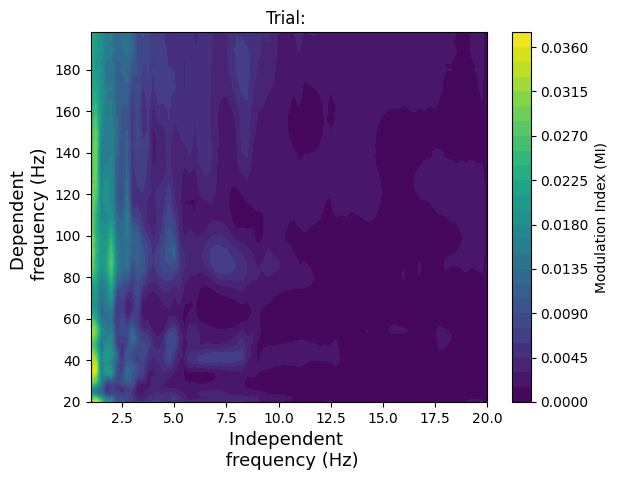

In [ ]:
plot_comodulogram(loaded_dict['trial_694'],loaded_dict['ind_freqs'],loaded_dict['dep_freqs'])

### MI curve

In [ ]:
def load_trial_comodulograms_dict(rat_id,day_id):
  PFC_channel = session_preferred_channels[f'rat{rat_id}_day{day_id}']
  STR_channel = alternative_channels[f'rat{rat_id}_day{day_id}']

  with open(f'/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp'\
  f'/all_channels/data/separated_channels/rat{rat_id}_day{day_id}_LFP_all/results/individual_trial_comodulograms/comodulograms_dict_ch{PFC_channel}.pkl', 'rb') as f_pfc:
    PFC_comods = pickle.load(f_pfc)

  with open(f'/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp'\
  f'/all_channels/data/separated_channels/rat{rat_id}_day{day_id}_LFP_all/results/individual_trial_comodulograms/comodulograms_dict_ch{STR_channel}.pkl', 'rb') as f_str:
    STR_comods = pickle.load(f_str)

  print(f'PFC channel for rat {rat_id}, day {day_id}: ch_{PFC_channel}\nSTR channel for rat {rat_id}, day {day_id}: ch_{STR_channel})')
  return PFC_comods,STR_comods

def operation_on_comod_values_df(trialed_comodulograms_dict,session_data,rat_id,day_id,operation=np.mean):
  'Apply an operation (e.g. max; default is np.mean()) over all values in the comodulogram'

  rewarded_trials = trialed_comodulograms_dict.copy()

  ind_freqs = rewarded_trials.pop('ind_freqs')
  dep_freqs = rewarded_trials.pop('dep_freqs')

  # dictionary of rewarded trials whose entries are trial:max_value_in_trial_comodulogram
  operated_comod_values_in_rewarded_trials = {int((key[6:])):operation(value.flatten()) for key,value in rewarded_trials.items()}

  # a set of all trial ids in this session
  all_trials = set([int(trial_id) for trial_id in session_data.query('rat == 6 and day == 2').trial.unique()])

  # a dictionary of non-rewarded trials whose entries are trial:NaN so we can ignore them on a rolling average
  remaining_trials = {trial:float("NaN") for trial in all_trials.difference(set(operated_comod_values_in_rewarded_trials.keys()))}

  # combine rewarded and non-rewarded trial dictionaries
  all_trials_dict = operated_comod_values_in_rewarded_trials | remaining_trials # | is the merge operator

  #turn into dataframe, sorted by trials
  return pd.DataFrame(all_trials_dict.items(), columns=['trial', 'oped_comod_value']).sort_values('trial')

def rolling_avg_ignoring_nan(comods_df,target_column='oped_comod_value',window_length=20,min_periods=1):
  '''
  two strategies prevent a major influence of NaNs, i.e. missing values from non-rewarded trials whose length was lower than our criterion duration and for whom we have not estimated comodulograms:
      1. min_periods = 1 assures that even if 19/20 points are NaN (e.g. 1 rewarded trial followed by 19 non-rewarded ones) it'll not return a NaN.
                            in such case the average is this sole value; this resembles the learning curve, for non-rewarded trials do not alter the cumulative progress made prior
      2. using np.nanmean() over all values in the window [the lambda below] to ignore NaN observations upon calculating the mean
                            (not dilluting the value of non-NaN entries by their mere presence as a 0 would)
  '''

  return comods_df[target_column].rolling(window=20,min_periods=1).apply(lambda x : np.nanmean(x)).values

In [ ]:
def plot_rolling_averages_panel(rat_id,day_id,session_data,window_length=20):
  PFC_comods_dict,STR_comods_dict = load_trial_comodulograms_dict(rat_id,day_id)
  session_of_interest = session_data.copy().query(f'rat == {rat_id} and day == {day_id}').sort_values('trial')

  ## Example:
  fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, sharex=True,figsize=(16,9))

  #ax1 - average modulation index
  ax1.plot(rolling_avg_ignoring_nan(operation_on_comod_values_df(PFC_comods_dict,session_data.copy(),rat_id=rat_id,day_id = day_id,operation=np.mean)),label='PFC',color='tomato')
  ax1.plot(rolling_avg_ignoring_nan(operation_on_comod_values_df(STR_comods_dict,session_data.copy(),rat_id=rat_id,day_id = day_id,operation=np.mean)),label='STR',color='slateblue')

  ax1.set_title(f'Average Modulation Index (MI) in window ({window_length} trials)')
  ax1.set_ylabel('Modulation Index (a.u.)')
  ax1.legend()

  #ax2 - percent correct in window
  percent_correct = ((pd.Series([trial_duration > 1.5 for trial_duration in session_of_interest.sort_values('trial').duration.unique()]).rolling(window=20,min_periods=1).sum().values)/20)*100

  ax2.set_title(f'Percentage of rewarded trials in window ({window_length} trials) ')
  ax2.plot(percent_correct,label='Percent correct in the window (Learning curve)',color='olivedrab')
  ax2.set_ylabel('Percent correct (%)')
  ax2.legend()
  ax2.set_ylim([0,100])

  #ax3 - average duration in window
  avg_duration = ((pd.Series([trial_duration for trial_duration in session_of_interest.sort_values('trial').duration.unique()]).rolling(window=20,min_periods=1).apply(np.mean).values))

  ax3.set_title(f'Average trial duration in window ({window_length} trials)')
  ax3.plot(avg_duration,label='Average duration in window',color='teal')
  ax3.axhline(y=1.5,linestyle=':',color='red',linewidth=0.7,label='Criterion duration')
  ax3.set_xlabel('Trial (#)')
  ax3.set_ylabel('Average duration (s)')
  ax3.legend()
  ax3.set_ylim([0,3])

  plt.suptitle(f'Session: Rat {rat_id}, day {day_id}')
  plt.tight_layout()

PFC channel for rat 4, day 1: ch_18
STR channel for rat 4, day 1: ch_28)
PFC channel for rat 4, day 2: ch_18
STR channel for rat 4, day 2: ch_28)
PFC channel for rat 5, day 1: ch_9
STR channel for rat 5, day 1: ch_24)
PFC channel for rat 5, day 2: ch_9
STR channel for rat 5, day 2: ch_24)
PFC channel for rat 6, day 1: ch_10
STR channel for rat 6, day 1: ch_0)
PFC channel for rat 6, day 2: ch_10
STR channel for rat 6, day 2: ch_0)


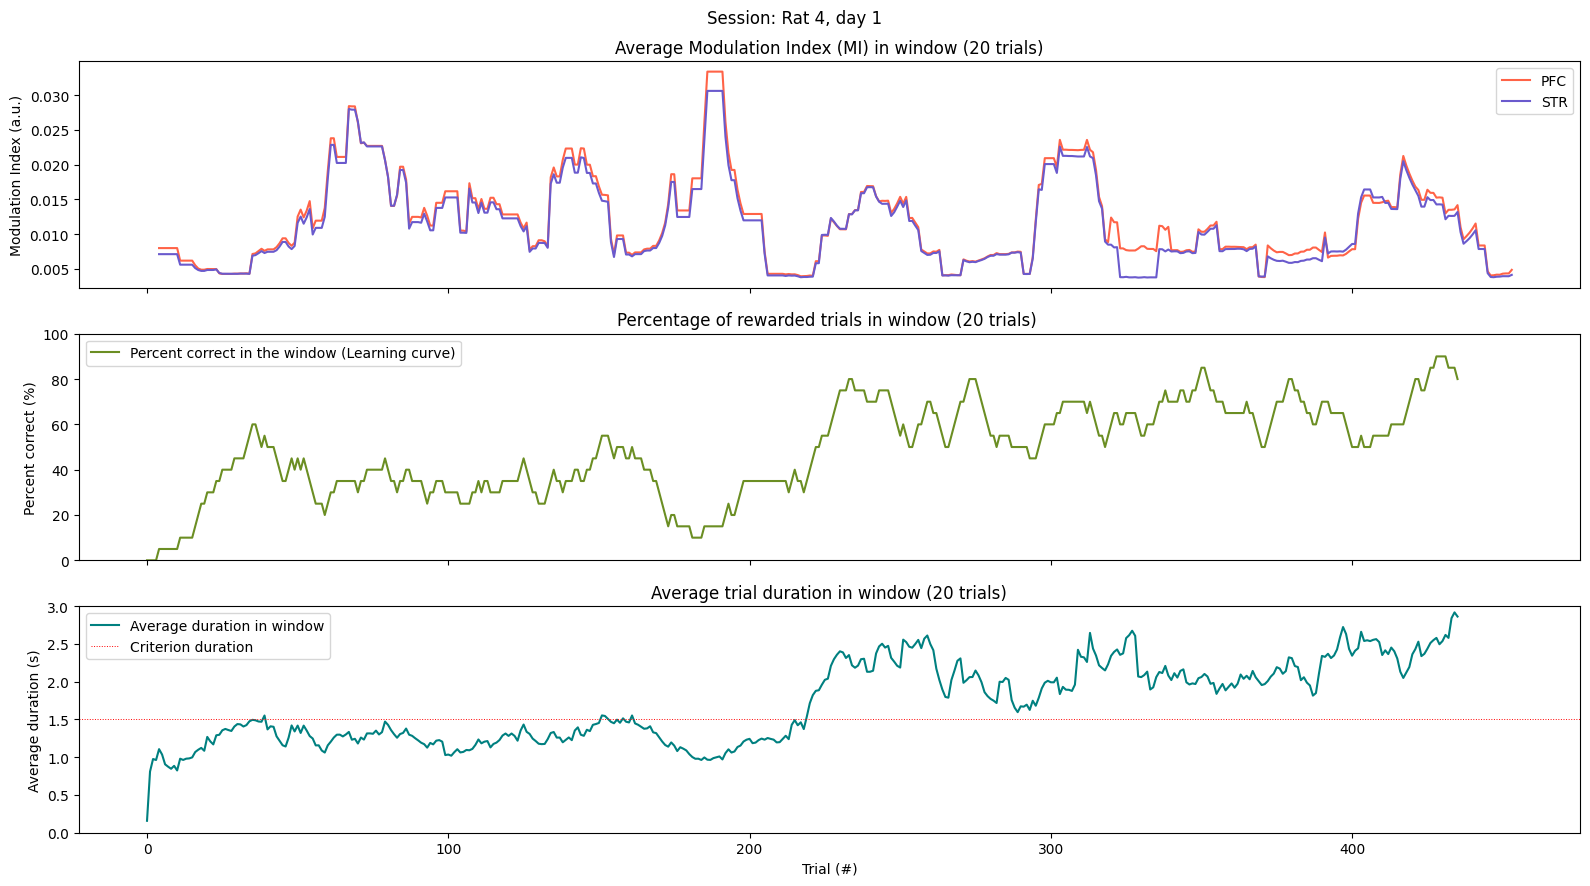

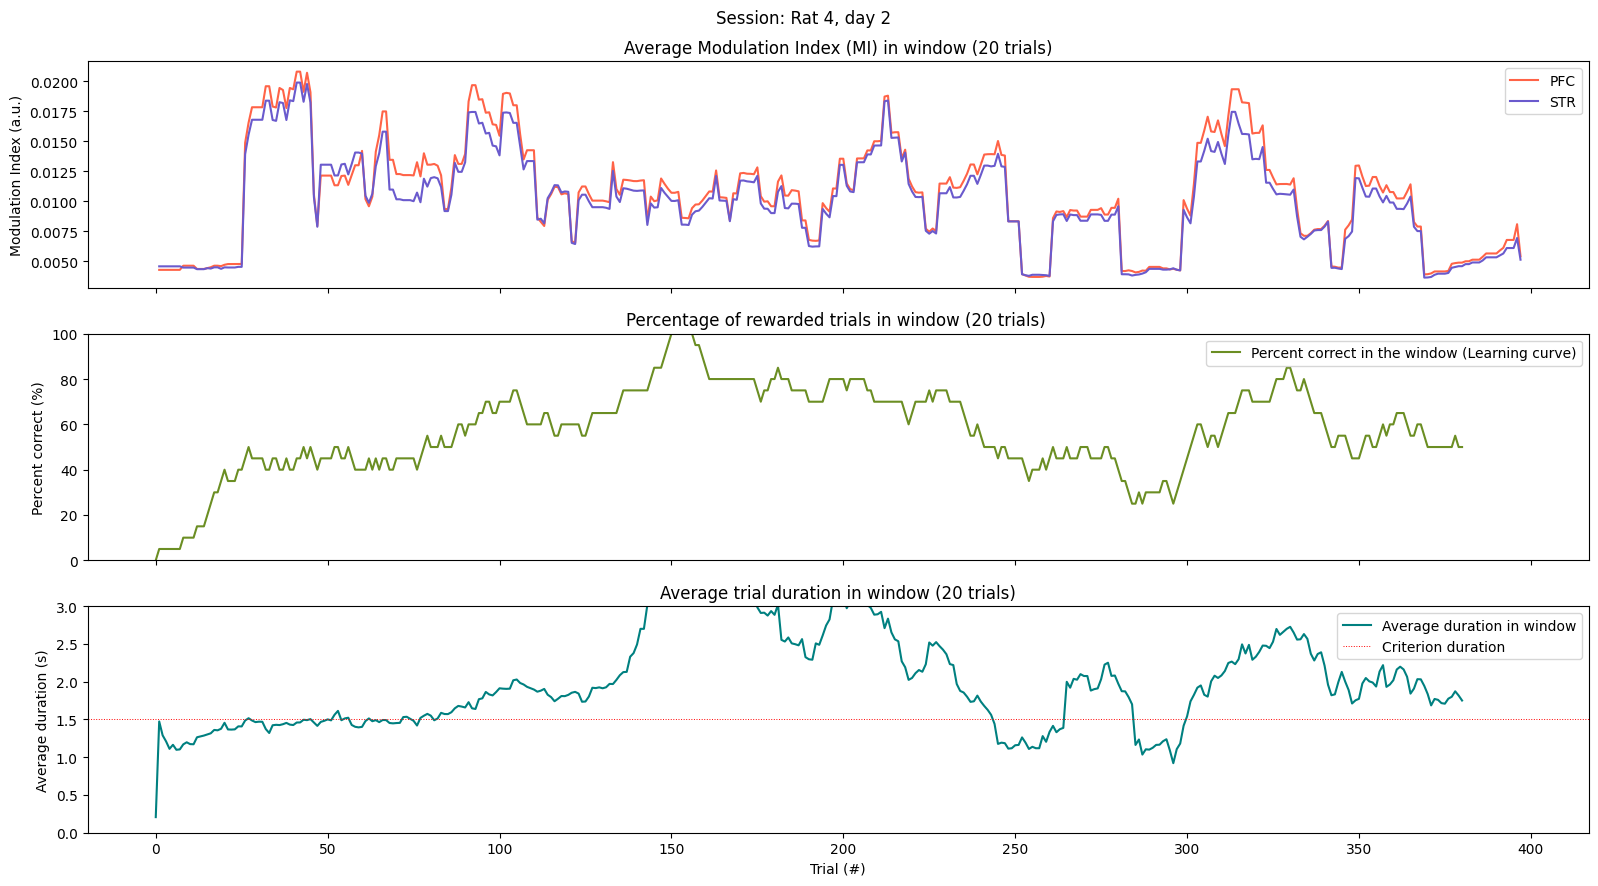

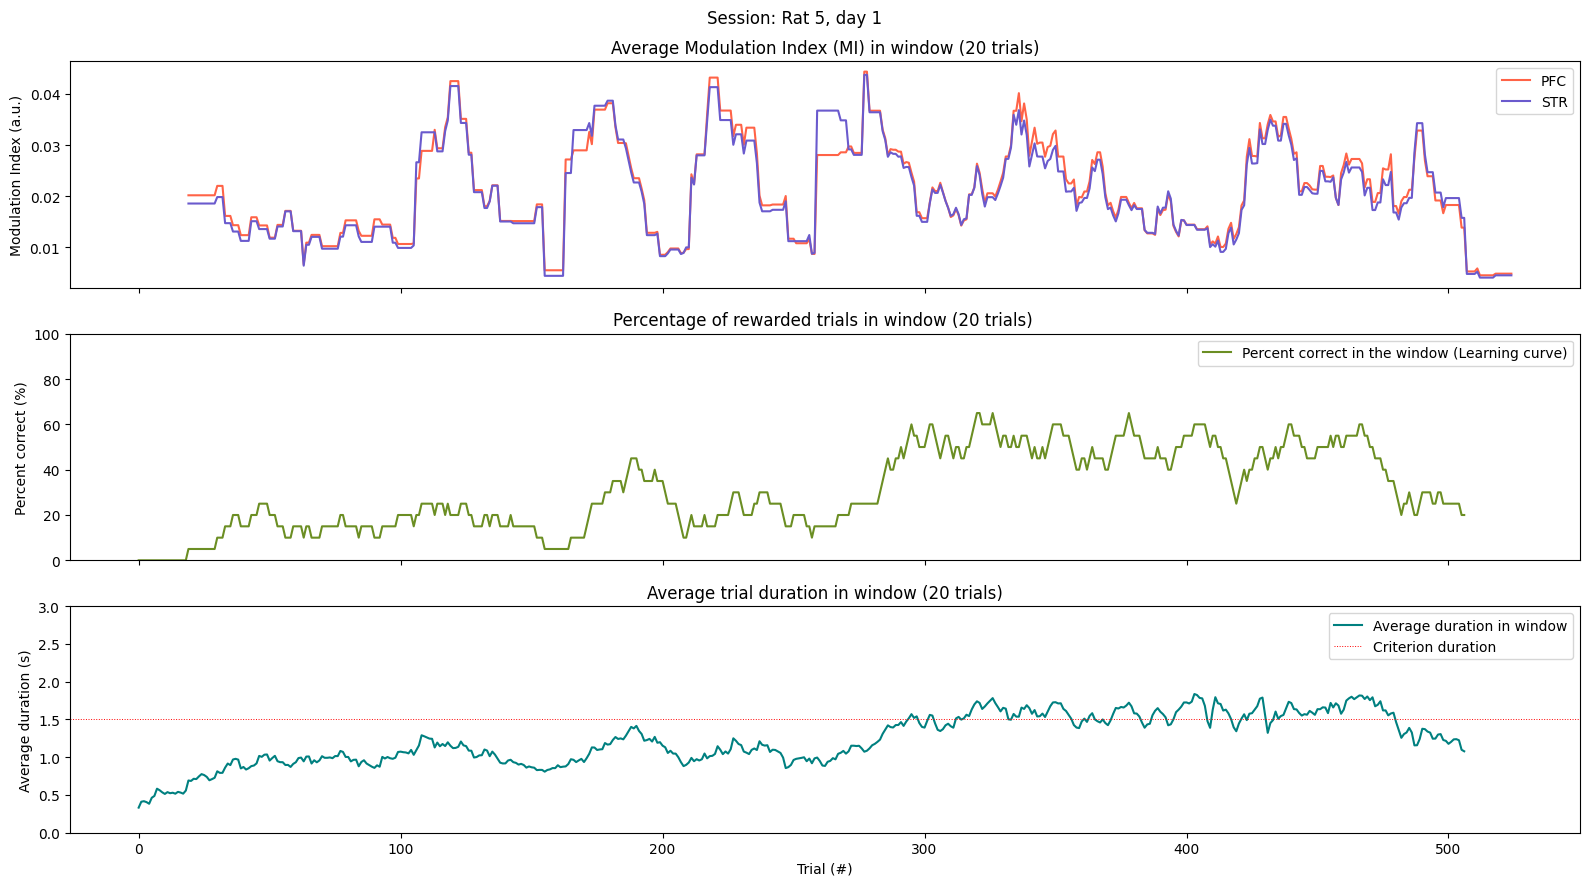

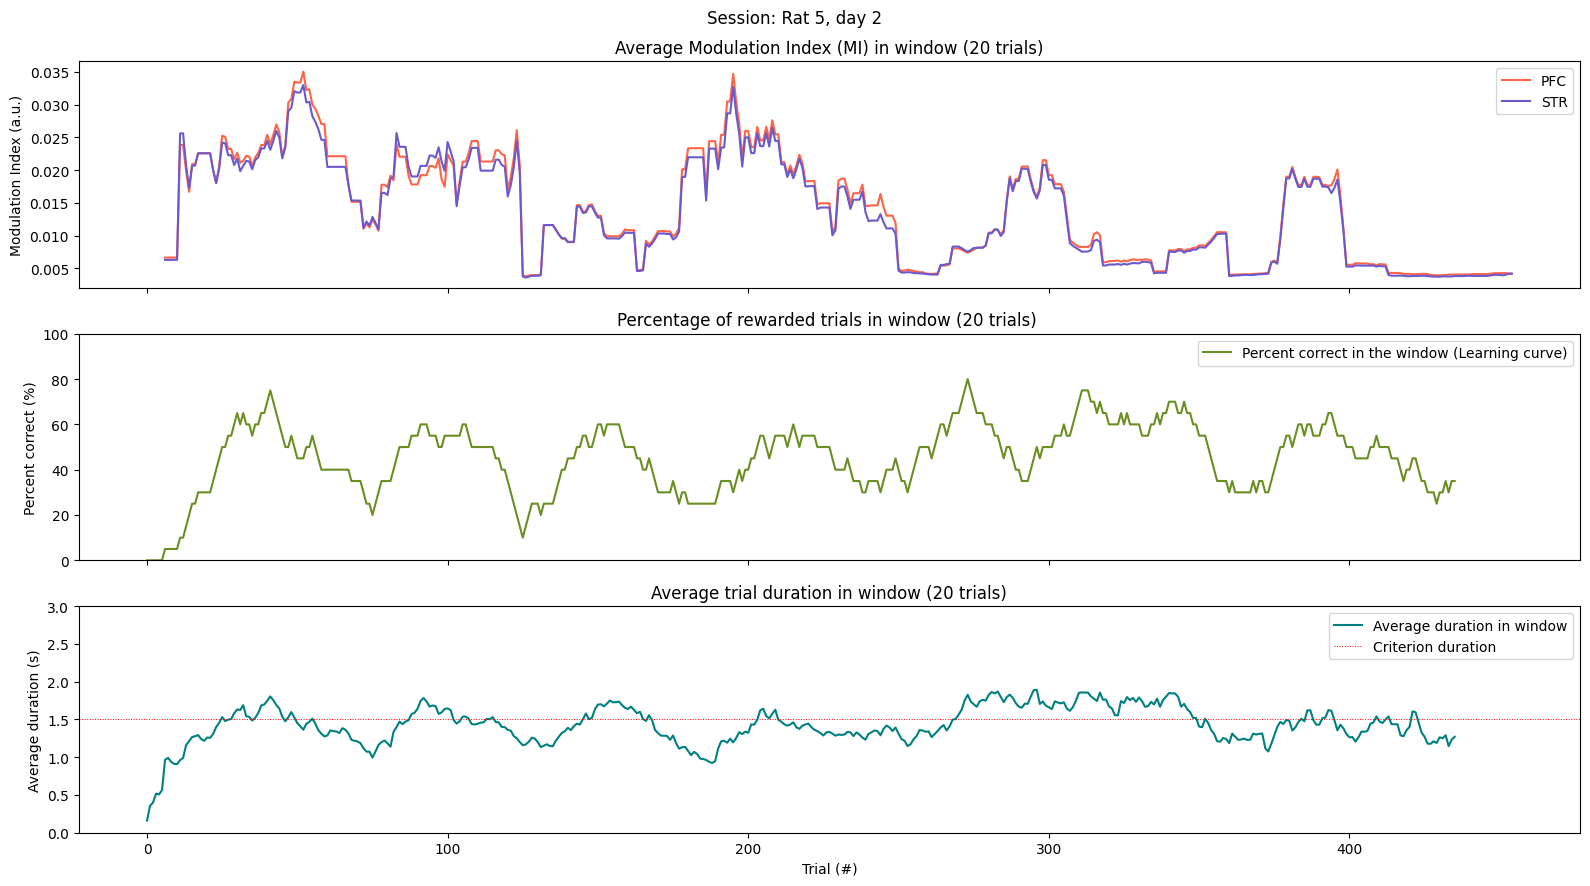

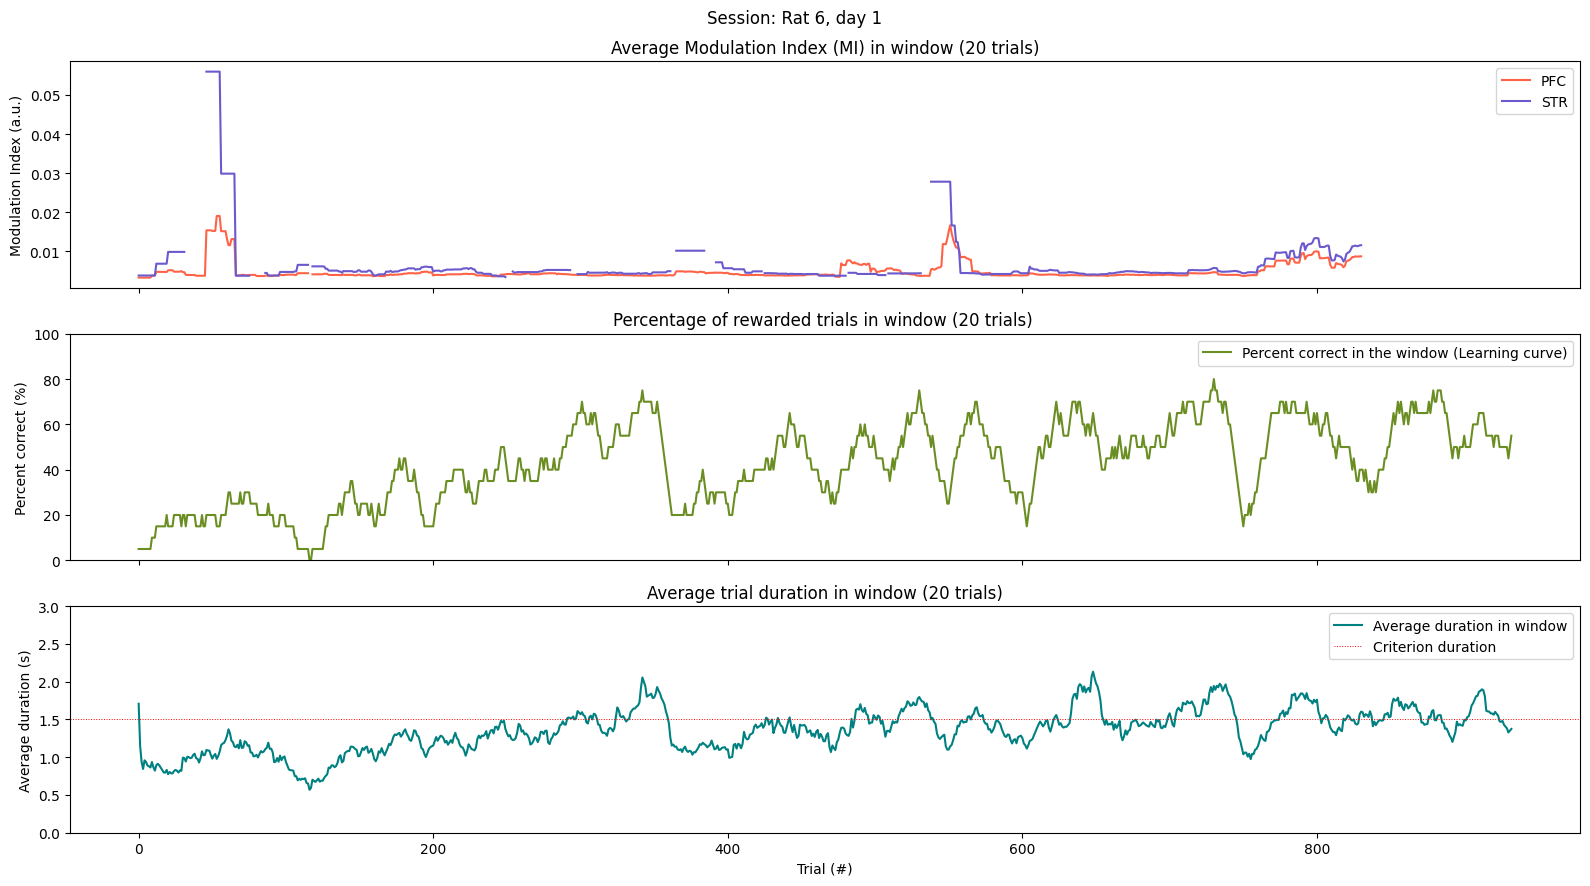

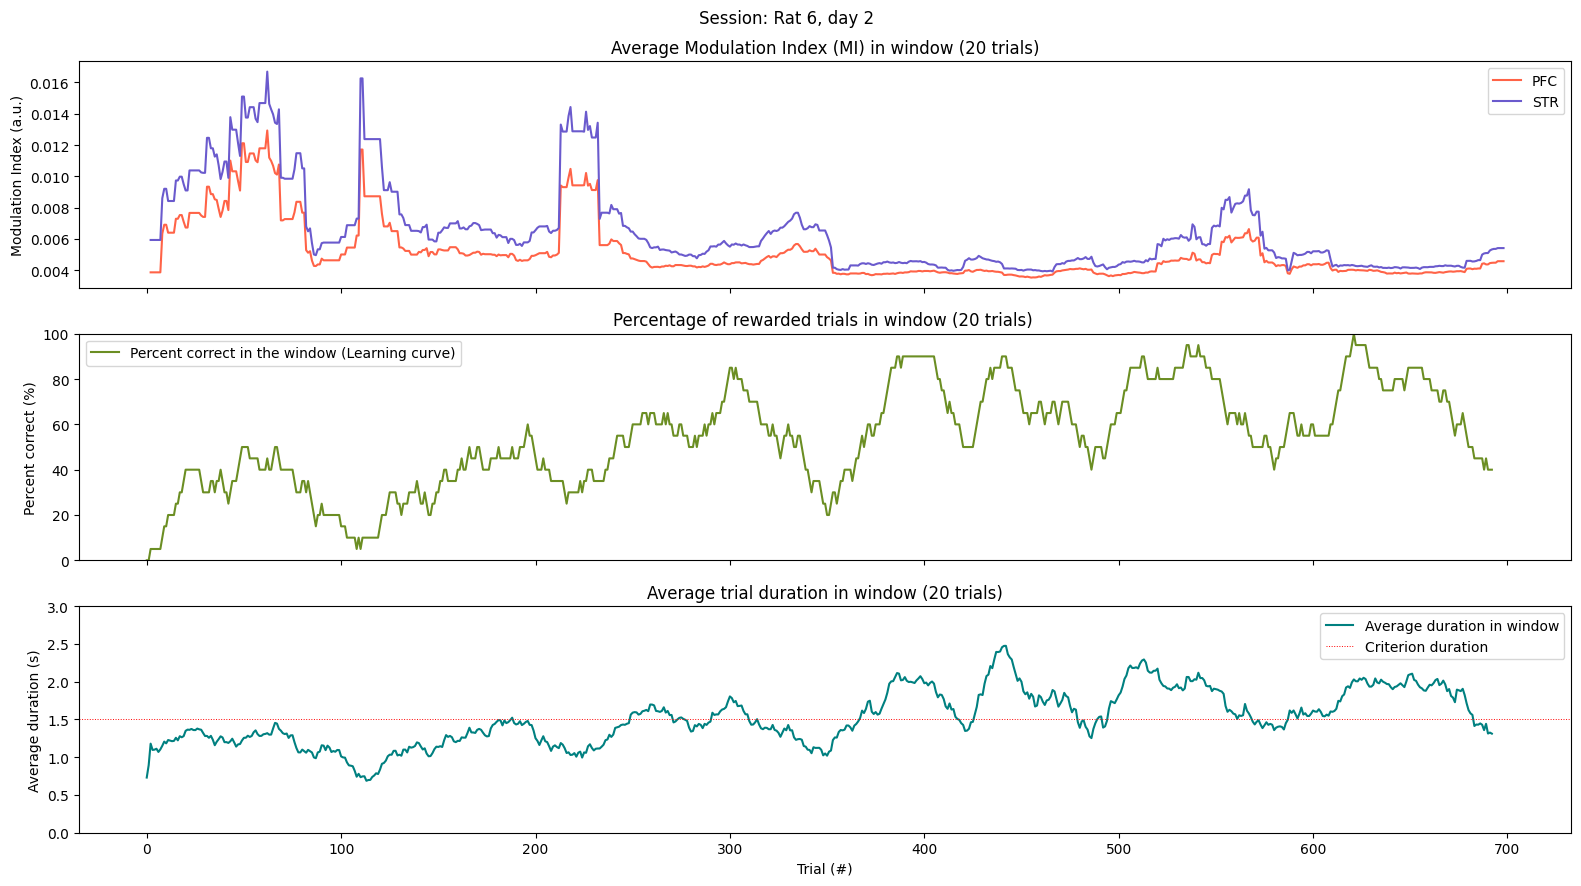

In [ ]:
session_data = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/session_data-spikes.csv').copy()

for rat in range(4,7):
  for day in range(1,3):
    plot_rolling_averages_panel(rat,day,session_data,window_length=20)

# testing the MI/comodulogram estimation algorithm

### Sleep data

In [ ]:
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

data_states = sio.loadmat('./data/state_scoring/rat4_day2/2017-05-07_13-57-27.SleepState.states.mat')

data_episodes = sio.loadmat('./data/state_scoring/rat4_day2/2017-05-07_13-57-27.SleepStateEpisodes.states.mat')

data_scores = sio.loadmat('./data/state_scoring/rat4_day2/2017-05-07_13-57-27.SleepScoreLFP.LFP.mat')

In [ ]:
#load data from rat 4, day 2:
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

rat = 4
day = 2

animal_label = f'rat{rat}_day{day}'

os.chdir(f'./data/separated_channels/{animal_label}_LFP_all')
print('current session: ',os.getcwd())

#with open("./metadata.json", "r") as fp:
#    meta_data = json.load(fp) #load the JSON with metadata
#data_sampling_rate = meta_data['sampling_rate'] #from it fetch the sampling rate of the loaded data
#data_sampling_rate = 1250

lfp,channel,region = load_lfp(rat_id = rat,day_id = day,channel_id = 18)

current session:  /content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat4_day2_LFP_all


In [ ]:
#This encodes the timestamps [begin, end] for each event of a given state
#data_states['SleepState'][0][0][0][0]

#Timestamps for awake states
awake_timestamps = data_states['SleepState'][0][0][0][0][0][0]

#Timestamps for pathological states
pathological_timestamps = data_states['SleepState'][0][0][0][0][0][1]

#Timestamps for NREM states
nrem_timestamps = data_states['SleepState'][0][0][0][0][0][2]

#Timestamps for REM states
rem_timestamps = data_states['SleepState'][0][0][0][0][0][3]

#'''caution: I have figured which timestamps belong to which state due to the dtypes assigned at the level of "data_states['SleepState'][0][0][0][0]", but it might be a mistake of mine

In [ ]:
freqs_for_amps = np.arange(30,202,2)
freqs_for_phases = np.arange(1,20.25,.25)

print(len(freqs_for_phases),len(freqs_for_amps))

77 86


In [ ]:
first_asleep_state = lfp.query(f'timestamps > {nrem_timestamps[0][0]} and timestamps <= {nrem_timestamps[0][1]}')
first_awake_state = lfp.query(f'timestamps > {awake_timestamps[0][0]} and timestamps <= {awake_timestamps[0][1]}')
first_pathological_state = lfp.query(f'timestamps > {pathological_timestamps[0][0]} and timestamps <= {pathological_timestamps[0][1]}')

2632 3010
7280 8335


Text(0, 0.5, 'LFP')

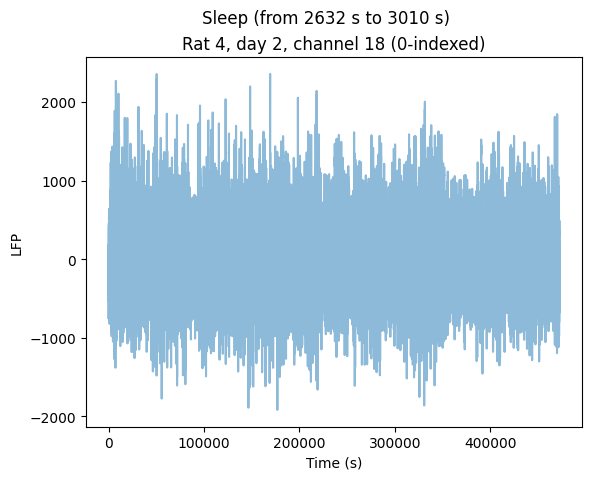

In [ ]:
print(nrem_timestamps[0][0],nrem_timestamps[0][1])
print(nrem_timestamps[1][0],nrem_timestamps[1][1])

#vamos escolher o primeiro período de sono:
[nrem_timestamps[i][1] - nrem_timestamps[i][0] for i in range(len(nrem_timestamps))]

signal = lfp.query(f'timestamps > {nrem_timestamps[0][0]} and timestamps <= {nrem_timestamps[0][1]}').lfp.values
plt.suptitle(f'Sleep (from {nrem_timestamps[0][0]} s to {nrem_timestamps[0][1]} s)')
plt.title('Rat 4, day 2, channel 18 (0-indexed)')
plt.plot(signal,alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('LFP')
#plt.xticks(plt.xticks()[0],labels = [int(tick)/1250 + nrem_timestamps[0][0] for tick in plt.xticks()[0]])
#plt.xlim(left=-5000,right=480000.0)

In [ ]:
comod, ind_freqs, dep_freqs = comodulogram2(signal)

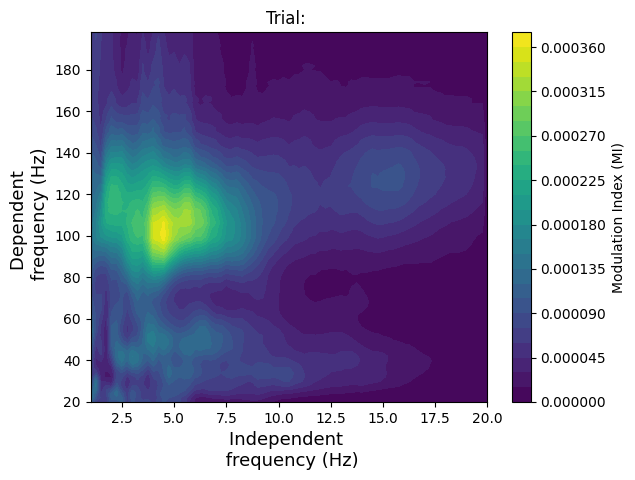

In [ ]:
plot_comodulogram(comod,ind_freqs,dep_freqs)

(90, 77) (77,) (90,)


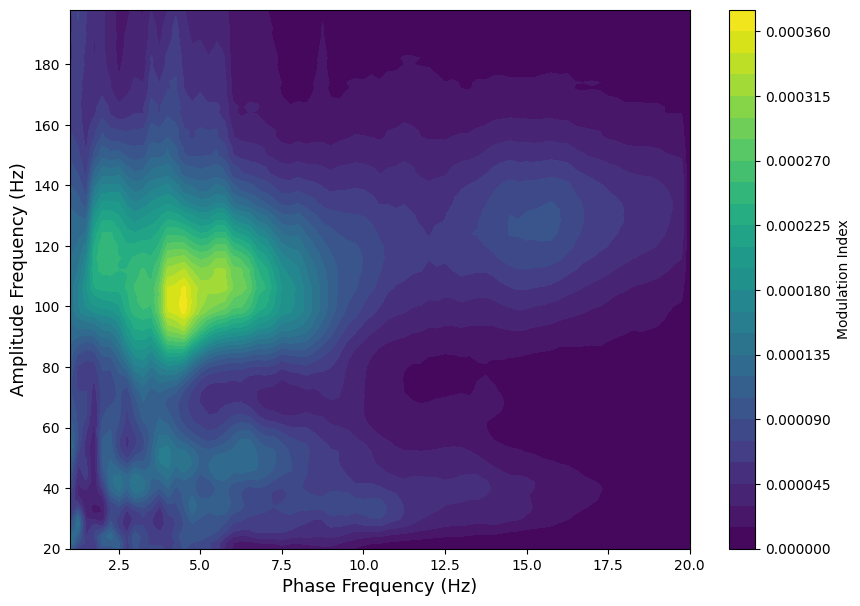

In [ ]:
#dimensions
print(np.shape(comod),np.shape(ind_freqs),np.shape(dep_freqs[0:-1]))

#contour plot
plt.figure(figsize=(10,7))
plt.contourf(ind_freqs,dep_freqs[0:-1],comod,30)
plt.xlabel('Phase Frequency (Hz)',size=13)
plt.ylabel('Amplitude Frequency (Hz)',size=13)
plt.colorbar(label="Modulation Index");

# Cross-frequency coupling during NREM sleep

Estimated from one channel per rat on all its asleep periods

### Figures to generate:
Panel 1:
- Average comodulogram before training vs. after training

Panel 2:
- Point plot comparing MI values before/after training (as in Eliezyer's dissertation, fig. 3.2.3.g-h)

In [ ]:
def separate_intervals(state_timestamps,session_data,rat_id,day_id):
  '''
  Separate the intervals of a given state (REM sleep, nREM sleep, awake or micro-seizure) as happening either before or after training
  discarding whichever interval happens within the training session

  Parameters
  ----------
  state_timestamps: iterable
          The LFP signal whose bands will be probed for coupling
  session_data: pandas DataFrame
          A DataFrame containing all information regarding the sessions, including the beginning/end timestamps of each one
  rat_id: int
          The chosen animal
  day_id: int
          The day in which the session happened

  Returns
  ----------
  state_ocurrences_before_training,state_ocurrences_after_training: list
          Selection of states that happen respectively before/after training

  '''


  state_ocurrences_before_training = []
  state_ocurrences_after_training = []

  #Query for the desired session and find the first and last timestamp, corresponding to the beginning and end of the training protocol during this session
  training_begin = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min()
  training_end = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()
  #print(training_begin,training_end)

  for sleep_period_index,period_limits in enumerate(state_timestamps):
    if period_limits[0] < training_begin:
      state_ocurrences_before_training.append(state_timestamps[sleep_period_index])
    elif period_limits[0] > training_end:
      state_ocurrences_after_training.append(state_timestamps[sleep_period_index])
    else:
      pass

  return state_ocurrences_before_training,state_ocurrences_after_training

def split_lfp_states(lfp_df,timestamps_list):

    '''separate the lfp df into a dictionary of segments, whose keys are segment identifiers (index in the timestamps list) and
    values are dfs corresponding to excerpts of the whole lfp signal that fall between
    each state's time boundaries [state begin, state end]'''

    states_dict = {}
    for state_id,state_limiting_timestamps in enumerate(timestamps_list):
        '''upon profiling this function to probe its performance I have concluded it is very slow
        the pieces of code that were taking too long were these queries below, so I'll comment them out and implement another querying method (expression matching on Series.values)
        nonetheless, I will leave them for the sake of comprehension of what is going on in the following expression, which yields the same but in a fraction of the elapsed time
        '''

        #extract the timestamps for the beginning and end of trial using the 1st
        #spike (begin) and total duration (end)
        begin = state_limiting_timestamps[0]
        end = state_limiting_timestamps[1]

        #fetch the lfp data within these two timepoints and add to the dict as our state
        current_lfp = lfp_df[(lfp_df.timestamps.values >= (begin)) & (lfp_df.timestamps.values <= end)].lfp.values

        states_dict[state_id] = current_lfp
    print('done parsing the LFP into state intervals')

    return states_dict

def estimate_comodulogram(signal,modulating_freqs,modulated_freqs,num_bins=50,sampling_rate=1250):
  '''
  Estimate the Modulation Index (MI) for each pair of frequencies (one whose phase is modulating the amplitude of the other) among all specified
  and return the matrix with all the MIs (the comodulogram).

  Parameters
  ----------
  signal: (NumPy) array
          The LFP signal whose bands will be probed for coupling
  modulating_freqs: iterable
          The modulating frequencies (Hz) in crescent order (e.g. [1,1.25,1.5,...,20])
  modulated_freqs: iterable
          The modulated frequencies (Hz) in crescent order (e.g. [20,22,24,...,200])
  num_bins: int [default: 50]
          Number of bins in which to divide the phase of the modulating frequency (e.g. 360 deg/50 bins = 7.2 deg per bin)
  sampling_rate: float [default: 1250]
          The sampling rate of the original signal

  Returns
  ----------
  current_comod: (NumPy) array
          A 2D matrix comprised of the MI for each pair of frequencies in both the modulating and modulated ranges
  '''

  current_comod = np.zeros([len(modulated_freqs) - 1, len(modulating_freqs)])

  filtered_phases = np.empty([len(modulating_freqs) - 1,len(signal)])

  from scipy.signal import hilbert

  for phase_index,phase in enumerate(modulating_freqs[0:-1]):
    filtered_phases[phase_index,:] = np.angle(hilbert(band_extraction(signal,cutoff_low=modulating_freqs[phase_index],cutoff_high=modulating_freqs[phase_index+1],
                                              sampling_rate=sampling_rate)))

  phasebins = np.linspace(-np.pi,np.pi,num_bins+1)
  phasecenters = phasebins[0:-1] + (phasebins[1] - phasebins[0])


  #iterate over signals filtered at higher frequencies (each band for which we extract the amplitude envelope)
  for amp_index,current_amp in enumerate(modulated_freqs[:-1]):
    #print(f'new amp: [{amp_index}/{len(modulated_freqs)-1}]')
    amp_envelope = abs(hilbert(band_extraction(signal,cutoff_low=modulated_freqs[amp_index],cutoff_high=modulated_freqs[amp_index+1],
                                                    sampling_rate=sampling_rate)))

    '''
    to exploit the storage vs. processing conundrum, I have already filtered the signal in each low-frequency band of interest
    and put each band's signal in a vector (filtered_phases, 76 bands in total).
    once again I have opted for such an approach and below I create a vector called bins_freq,
    that will store each frequency bin's (from [-pi,pi]) mean amplitude in a single modulated band (from which we extract the amplitude envelope)
    '''

    bins_freq = np.empty((num_bins,len(filtered_phases)))

    for phase_bin_id in range(len(phasebins)-1):
      #print(phase_bin_id)
      #print(phasebins[phase_bin_id],phasebins[phase_bin_id+1])

      for band_id,band_signal in enumerate(filtered_phases):
        phasepoints_in_frequency_bin = np.where((band_signal > phasebins[phase_bin_id]) & (band_signal < phasebins[phase_bin_id+1]))[0]
        mean_amplitude_in_frequency_bin = np.mean(amp_envelope[phasepoints_in_frequency_bin])
        #print(mean_amplitude_in_frequency_bin)
        bins_freq[phase_bin_id,band_id] = mean_amplitude_in_frequency_bin

      #print(f'estimated mean amplitude in bin {phase_bin_id} [{phasebins[phase_bin_id]} Hz, {phasebins[phase_bin_id+1]} Hz] in all modulating bands!')
      #print(sum(bins_freq[:,band_id]))
    #print(f'finished all frequency bins for all modulating bands in this modulated band: [{modulated_freqs[amp_index]} Hz,{modulated_freqs[amp_index+1]} Hz]')
    #normalize over each phase bin, yielding what is dubbed p
    p = [bins_freq[:,band_id]/sum(bins_freq[:,band_id]) for band_id in range(len(filtered_phases))]

    #estimate MI
    from scipy.stats import entropy
    uniform_dist = np.ones(num_bins)/num_bins

    #iterating over all low-frequency filtered bands:
    for low_freq_band_index in range(np.shape(p)[0]):
      MI = entropy(p[low_freq_band_index],uniform_dist)/np.log(num_bins)
      current_comod[amp_index,low_freq_band_index] = MI

  print('Finished comodulogram')
  return current_comod

In [ ]:
def scored_state_probing(rat_id,day_id,session_data,lfp_channel_id,state_type='NREMstate'):
  '''
  Find all intervals of a given type in a session, separate them into happening either before or after the training session
  and estimate the comodulogram for each of them. Return two matrices, each comprised of the comodulograms in all intervals before/after training.

  Parameters
  ----------
  rat_id: int
          The chosen animal
  day_id: int
          The day in which the session happened
  session_data: pandas DataFrame
          A DataFrame containing all information regarding the sessions, including the beginning/end timestamps of each one
  lfp_channel_id: int
          ID of the channel [from 0 up to 31] to load for this animal
  state_type: string [default: "NREMstate"]
          The type of period which to probe. Options are: "NREMstate", "WAKEstate", "REMstate" and "events_pathologicalstate"

  Returns
  ----------
  state_comodulograms_before_training,state_comodulograms_after_training: [NumPy] array
          A matrix with all comodulograms of states that happen respectively before/after training

  '''
  print(f'Beginning the estimate of comodulograms of {state_type.removesuffix("state")} states from session:\n(Rat: {rat_id}, day: {day_id}) using LFP channel {lfp_channel_id} (0-indexed)')

  #Query for the desired session and find the first and last timestamp, corresponding to the beginning and end of the training protocol during this session
  training_begin = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min()
  training_end = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()

  #Load the timestamps for each event (e.g. sleep, pathological states) as a list

  #We set up these conditionals just for rat 4, whose folders are differently named from the pattern
  if rat_id == 4 and day_id == 1:
    day_tag = '2017-05-06_09-58-35'
  elif rat_id == 4 and day_id == 2:
    day_tag = '2017-05-07_13-57-27'
  else:
    day_tag = f'Day{day_id}'

  state_scores_path = f'/content/drive/MyDrive/MSc/Rat{rat_id}/{day_tag}'

  #Load the state scoring timestamps proper
  data_states = sio.loadmat(state_scores_path+f'/{day_tag}.SleepState.states.mat')

  #Not all sessions have pathological states
  if state_type == 'events_pathologicalstate':
    try:
      event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]
    except:
      raise('There are pathological (microseizure) states in this session.')
  #But all others are guaranteed
  else:
    event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]

  #Separate events into either happening before or after training
  events_before_training,events_after_training = separate_intervals(event_timestamps,session_data,rat_id,day_id)

  #just print either 'NREM', 'REM', 'WAKE' or 'events_pathological', withouth the 'state' suffix appended to the strings
  print(f'There are {len(events_before_training)} '+state_type.removesuffix("state")+' periods before training')
  print(f'There are {len(events_after_training)} '+state_type.removesuffix("state")+' periods after training')

  #Create two 3D matrices, one for before training and one for after training, whose dimensions are {number of periods, modulating frequencies, modulated frequencies}
  #i.e. a matrix with K comodulograms, being MxN each (M being the number of modulating frequencies probed and N the modulated ones)

  #These are the frequencies over which we will build the comodulogram; for now I am making them fixed but later they will be incorporated as parameters
  freqs_for_amps = np.arange(30,202,2)
  freqs_for_phases = np.arange(1,20.25,.25)

  def states_comodulograms_matrix(states_timestamps,freqs_for_amps,freqs_for_phases):
    '''Build a 3D matrix with dimensions {number of events, number of frequencies probed for being modulated, number of frequencies probed for being modulating of the former}'''
    comods_over_states = np.zeros([len(states_timestamps),len(freqs_for_amps) - 1, len(freqs_for_phases)])
    return comods_over_states

  comods_before_training = states_comodulograms_matrix(events_before_training,freqs_for_amps,freqs_for_phases)
  comods_after_training = states_comodulograms_matrix(events_after_training,freqs_for_amps,freqs_for_phases)

  print(np.shape(comods_before_training))
  print(np.shape(comods_after_training))

  #7. Load the LFP corresponding to this session (recordings from its best channel)

  animal_label = f'rat{rat_id}_day{day_id}'

  #1. Load the spikes' dataframe
  os.chdir(f'/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/separated_channels/{animal_label}_LFP_all')

  lfp,channel,region = load_lfp(rat_id = rat_id,day_id = day_id,channel_id = lfp_channel_id)

  #Split this (whole) LFP signal into the periods of interest both before and after training
  before_training_lfps = split_lfp_states(lfp,events_before_training)
  after_training_lfps = split_lfp_states(lfp,events_after_training)

  #Estimate the comodulogram for each LFP segment in each of the sections (before/after training) and store them into the matrix created above

  for segment_identifier,segment_lfp in before_training_lfps.items():
    print(f'Beginning segment {segment_identifier+1} out of {len(before_training_lfps)}')
    comods_before_training[segment_identifier,:,:] = estimate_comodulogram(segment_lfp,freqs_for_phases,freqs_for_amps)

  np.save(f'{state_type.removesuffix("state")}_comodulograms_before_training_rat{rat_id}-day{day_id}',comods_before_training)
  print('Finished all segments before training')

  for segment_identifier,segment_lfp in after_training_lfps.items():
    print(f'Beginning segment {segment_identifier+1} out of {len(after_training_lfps)}')
    comods_after_training[segment_identifier,:,:] = estimate_comodulogram(segment_lfp,freqs_for_phases,freqs_for_amps)

  np.save(f'{state_type.removesuffix("state")}_comodulograms_after_training_rat{rat_id}-day{day_id}',comods_after_training)
  print('Finished all segments after training')

  return comods_before_training,comods_after_training,freqs_for_phases,freqs_for_amps

In [ ]:
#1. Load the spikes' dataframe
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)
print(os.getcwd())
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

#each animal's leaast noisy channel as a dict {animal:channel}
ideal_channels = {
    'Rat3':11,
    'Rat4':18,
    'Rat5':9,
    'Rat6':10
}

/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels


In [ ]:
#2. Select the rat and day (session, that is)
rat_id = 6
day_id = 2

before,after,ind_freqs,dep_freqs = scored_state_probing(rat_id,day_id,session_data,lfp_channel_id=ideal_channels[f'Rat{rat_id}'],state_type='NREMstate')

Beginning the estimate of comodulograms of NREM states from session:
(Rat: 6, day: 2) using LFP channel 10 (0-indexed)
There are 6 NREM periods before training
There are 30 NREM periods after training
(6, 85, 77)
(30, 85, 77)
File not found. This error happens only to rat 6, day 2
done parsing the LFP into state intervals
done parsing the LFP into state intervals
Beginning segment 1 out of 6
Finished comodulogram
Beginning segment 2 out of 6
Finished comodulogram
Beginning segment 3 out of 6
Finished comodulogram
Beginning segment 4 out of 6
Finished comodulogram
Beginning segment 5 out of 6
Finished comodulogram
Beginning segment 6 out of 6
Finished comodulogram
Finished all segments before training
Beginning segment 1 out of 30
Finished comodulogram
Beginning segment 2 out of 30
Finished comodulogram
Beginning segment 3 out of 30
Finished comodulogram
Beginning segment 4 out of 30
Finished comodulogram
Beginning segment 5 out of 30
Finished comodulogram
Beginning segment 6 out of 30


In [ ]:
before = np.load('./NREM_comodulograms_before_training_rat3-day1.npy')
after = np.load('./NREM_comodulograms_after_training_rat3-day1.npy')

In [ ]:
#freqs_for_amps = np.arange(30,202,2)
#freqs_for_phases = np.arange(1,20.25,.25)

averaged_early = np.mean(before,axis=0)
averaged_late = np.mean(after,axis=0)

In [ ]:
plot_comodulogram(averaged_early)
plt.show()
plot_comodulogram(averaged_late)

TypeError: plot_comodulogram() missing 2 required positional arguments: 'ind_freqs' and 'dep_freqs'

In [ ]:
rat1_averaged_comods = {True:averaged_early,False:averaged_late}

In [ ]:
'''I need the average comodulogram over session phases (before/after training) to be in the following format to make my life easier:'''
#rat_id = {True:pre_session_average_comodulogram_matrix, False:post_session_average_comodulogram_matrix}

# Phase reset at trial onset/offset

Estimated from one channel per rat on all its asleep periods

### Figures to generate:
Panel 1:
- Phase reset panel at onset/offset (comparing to 500 ms prior)

#### Running PyCircStat's Kuiper test in Google Colab

There is one function needed to use the Kuiper test as implemented in the PyCircStat toolbox. This test is intended to be a circular statistics' analogue to the Kolmogorov-Smirnov for linear distributions.

Unfortunately, in the current implementation the test requires loading a table that is provided under a given direction, namely: "'/'.join(os.path.realpath(__file__).split('/')[:-2] + ['data/'])"

If one tries to load from that location using a Google Colab notebook it yields a loading error for location not found. The simplest solution I had in mind was to simply copy the source code for the kuiper() function and all its necessary appendages in order to run it locally within this notebook.

In [ ]:
!pip3 install pycircstat
!pip install nose #this is important so we can actually import pycircstats

import pycircstat
from pycircstat import descriptive, swap2zeroaxis
import warnings

@swap2zeroaxis(['alpha1', 'alpha2'], [0, 1])
def kuiper(alpha1, alpha2, res=100, axis=None):
    """
    The Kuiper two-sample test tests whether the two samples differ
    significantly.The difference can be in any property, such as mean
    location and dispersion. It is a circular analogue of the
    Kolmogorov-Smirnov test.
    H0: The two distributions are identical.
    HA: The two distributions are different.
    :param alpha1: fist sample (in radians)
    :param alpha2: second sample (in radians)
    :param res:    resolution at which the cdf is evaluated (default 100)
    :returns: p-value and test statistic
              p-value is the smallest of .10, .05, .02, .01, .005, .002,
              .001, for which the test statistic is still higher
              than the respective critical value. this is due to
              the use of tabulated values. if p>.1, pval is set to 1.
    References: [Batschelet1980]_ p. 112
    """

    if axis is not None:
        assert alpha1.shape[1:] == alpha2.shape[1:], "Shapes of alphas not consistent with computation along axis."
    n, m = alpha1.shape[axis], alpha2.shape[axis]

    _, cdf1 = _sample_cdf(alpha1, res, axis=axis)
    _, cdf2 = _sample_cdf(alpha2, res, axis=axis)

    dplus = np.atleast_1d((cdf1 - cdf2).max(axis=axis))
    dplus[dplus < 0] = 0.
    dminus = np.atleast_1d((cdf2 - cdf1).max(axis=axis))
    dminus[dminus < 0] = 0.

    k = n * m * (dplus + dminus)
    mi = np.min([m, n])
    fac = np.sqrt(n * m * (n + m))
    pval = np.asarray([_kuiper_lookup(mi, kk / fac)
                       for kk in k.ravel()]).reshape(k.shape)
    return pval, k


def _kuiper_lookup(n, k):
    ktable = load_kuiper_table()

    alpha = np.asarray([.10, .05, .02, .01, .005, .002, .001])
    nn = ktable[:, 0]

    isin = (nn == n)
    if np.any(isin):
        row = np.where(isin)[0]
    else:
        row = len(nn) - np.sum(n < nn) - 1

        if row == 0:
            raise ValueError('N too small.')
        else:
            warnings.warn(
                'N=%d not found in table, using closest N=%d present.' %
                (n, nn[row]))

    idx = (ktable[row, 1:] < k).squeeze()
    if np.any(idx):
        return alpha[idx].min()
    else:
        return 1.


@swap2zeroaxis(['alpha'], [1])
def _sample_cdf(alpha, resolution=100., axis=None):
    """
    Helper function for circ_kuipertest.
    Evaluates CDF of sample in thetas.
    :param alpha: sample (in radians)
    :param resolution: resolution at which the cdf is evaluated (default 100)
    :param axis: axis along which the cdf is computed
    :returns: points at which cdf is evaluated, cdf values
    """

    if axis is None:
        alpha = alpha.ravel()
        axis = 0
    bins = np.linspace(0, 2 * np.pi, resolution + 1)
    old_shape = alpha.shape
    alpha = alpha % (2 * np.pi)

    alpha = alpha.reshape((alpha.shape[0], int(np.prod(alpha.shape[1:])))).T
    cdf = np.array([np.histogram(a, bins=bins)[0]
                    for a in alpha]).cumsum(axis=1) / float(alpha.shape[1])
    cdf = cdf.T.reshape((len(bins) - 1,) + old_shape[1:])

    return bins[:-1], cdf

def load_kuiper_table():
  _data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data'
  return np.load(_data_path + '/kuiper_table.npy')

### Phase reset analysis proper

In [ ]:
#1. Load the spikes' dataframe
data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)
print(os.getcwd())
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

#each animal's leaast noisy channel as a dict {animal:channel}
ideal_channels = {
    'Rat3':11,
    'Rat4':18,
    'Rat5':9,
    'Rat6':10
}

In [ ]:
#2. Select the rat and day (session, that is)
#rat_id = 3
#day_id = 1

#before,after = scored_state_probing(rat_id,day_id,session_data,lfp_channel_id=ideal_channels[f'Rat{rat_id}'],state_type='NREMstate')

In [ ]:
def phase_reset_dists(peri_trials_dict,peri_trial = 0.5,window_width=0.1,min_freq=1,bandwidth = 19,sampling_rate=1250,from_the_beginning=True):

  '''
  estimate the circular mean of the LFP phase in a window following a target instant and in a window at some peri-target vicinity that happens before it
  e.g.:
        - target = 0 ms (trial beginning), peri-target = -500 ms (500 ms before trial begins)
        - target = EOT (end-of-trial), peri-target = -500 ms (500 ms before trial ends)

    example: peri_trial = 0.5 s; window_dith = 0.1 s => compare [-500 ms, -400ms] to [0 ms, 100 ms]

  input:
      - peri_trials_dict [dict]: {key:value} pairs are {trial:LFP} with LFP being the (continuous) signal cropped from durations [-peri_target,trial_duration]
                                  (see the split_lfp_trials() function)
      - min_freq, bandwidth [float, Hz]: the range in which the LFP will be filtered is from [min_freq,min_freq+bandwidth]
      - peri_trial [float, s]: how many seconds the peri-target vicinity is displaced from the target instant
      - window_width [float, s]: the timespan after which the signal at either the phases of peri- or target instants will be (circularly) averaged out

  output:
      - peri_phases,target_phases [dict]: the {key:value} pairs are {trial [type - string]: mean phase over either the peri-target or target instant + window [type - np.array]}
  '''

  #if there is no SciPy loaded it will prompt a failure, for we use scipy.stats.circmean and scipy.signal.hilbert
  assert scipy

  # number of points peri-target onset (either trial beginning or end)
  peri_points = int(peri_trial*sampling_rate)

  # number of points from the target onset and afterwards
  points_in_window = int(window_width*sampling_rate)

  # the total number of points
  num_points = (2*points_in_window) + peri_points

  peri_phases = {}
  target_phases = {}

  for trial in peri_trials_dict.keys():
    #fetch the signal corresponding to the period of the whole trial with peri-onset durations included (e.g. - 500 ms)
    current_lfp_analytic = scipy.signal.hilbert(band_extraction(peri_trials_dict[trial].lfp,cutoff_low=min_freq,cutoff_high=min_freq+bandwidth,
                                               sampling_rate=sampling_rate))
    lfp_phase = np.angle(current_lfp_analytic) # lfp phase

    if from_the_beginning == True:
      #trim the trial from the beginning
      lfp_phase = lfp_phase[0:num_points]
    else:
      #trim the trial from the end, so the first point (index 0) coincides with the instant to be compared with the trial end
      lfp_phase = lfp_phase[-num_points:]

    #get the mean phase from the beginning of the considered duration (peri-target instant + window)
    peri_phases.update({trial: scipy.stats.circmean(lfp_phase[0:points_in_window])})

    #get the mean phase from the target duration (all points in the peri_points [e.g. 625 for 500 ms of peri-trial interval at 1250 Hz of sampling rate] + 100ms window)
    target_phases.update({trial: scipy.stats.circmean(lfp_phase[peri_points:peri_points+points_in_window])})

  return peri_phases,target_phases

In [ ]:
def channel_phase_reset(rat,day,channel,from_the_beginning=True,min_duration=0.8,peri_trial = 0.5,window_width=0.1,min_freq=1,bandwidth = 19,sampling_rate=1250,per_slice=1300):

  #os.chdir(f'./data/separated_channels/rat{rat}_day{day}_LFP_all')

  import json
  with open("./channel_region", "r") as fp:
    channel_region_pairs = json.load(fp) #load the JSON with channel-region pairings


  #Estimate phase distributions for both a 100 ms window at both a peri-trial instant and at trial beginning over all channels

  #This is the dictionary we will save the results
  channel_phasedist_results = {}

  lfp,channel,region = load_lfp(rat_id = rat,day_id = day,channel_id = channel[2:])

  #split the continuous signal into the segments belonging to each trial (time-consuming, ~1.3s, I should speed it up)
  peri_trial_dict = split_lfp_trials(session_data,lfp,rat,day,region,min_duration=min_duration,sampling_rate=sampling_rate,
                                     slicing='none',peri_trial_inclusion = peri_trial,per_slice=per_slice)

  #Estimate the phase reset distributions (circular mean of phase in each timespan: peri-trial or in-trial windows)
  pre_phases, target_phases = phase_reset_dists(peri_trial_dict,peri_trial = 0.5,window_width=0.1,min_freq=1,bandwidth = 19,sampling_rate=1250,from_the_beginning=from_the_beginning)

  #Save the values of each as a NumPy array into another dict indexed by the key "channel" (e.g. 'ch0'), comprising both results for that channel
  peri_phases_dist = np.array(list(pre_phases.values()))
  target_phases_dist = np.array(list(target_phases.values()))

  return peri_phases_dist,target_phases_dist

In [ ]:
def plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=''):
  #Plot the results as a panel with 32 polar histograms of mean phase count

  #convert to ms
  peri_interval_size*=100
  window_size*=100

  #The results should be stored in a dictionary named channel_phasedist_results
  fig, axes = plt.subplots(nrows=8, ncols=4,figsize=(8,20))
  fig.subplots_adjust(hspace=0.5)

  if aligned_to == 'begin':
    labels = ('Peri-trial interval [-500 ms,-400 ms]','Trial beginning [0 ms,100 ms]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a peri-trial instant (-{peri_interval_size} ms) and at trial beginning'
  elif aligned_to == 'end':
    labels = (f'Mid-trial interval [EOT - {peri_interval_size} ms, EOT - {peri_interval_size+window_size} ms]',f'Trial end [EOT - {window_size} ms, EOT]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a mid-trial instant ({peri_interval_size} ms from trial end) and at trial end'

  fig.suptitle(suptitle_text)

  channel_counter = 0

  num_bins = 18
  bins = np.linspace(0,2*np.pi,num_bins+1)
  width = 2*np.pi/num_bins

  for ax in axes.flatten():
    pre_dist,trial_dist = channel_phasedist_results[f'ch{channel_counter}']

    channel_region = channel_region_pairs[f'ch{channel_counter}']

    if kuiper(pre_dist,trial_dist)[0] <= 0.05:
      colors = ['red','blue']
    else:
      colors = ['#b5b5b5','#525252']

    series1_counts,_ = np.histogram(pre_dist,bins)
    series2_counts,_ = np.histogram(trial_dist,bins)

    #only label the first two plots with significant statistics because otherwise we would have repeated labelling

    ax = plt.subplot(8, 4, channel_counter+1, projection='polar')

    if channel_counter == 0:
      #ax = plt.subplot(8, 4, channel_counter+1, projection='polar')
      label1 = ax.plot([], [], color='red',alpha=0.5,label=labels[0])
      label2 = ax.plot([], [], color='blue',alpha=0.5,label=labels[1])
      label3 = ax.plot([], [], color='#b5b5b5',alpha=0.5,label=labels[0]+'(Non-significant)')
      label4 = ax.plot([], [], color='#525252',alpha=0.5,label=labels[0]+'(Non-significant)')
    else:
      labels = (None,None)
    series1_bars = ax.bar(bins[:num_bins], series1_counts, width=width, bottom=0.0,color=colors[0],alpha=0.5)
    series2_bars = ax.bar(bins[:num_bins], series2_counts, width=width, bottom=0.0,color=colors[1],alpha=0.5)

    plt.title(f'Channel: {channel_counter} \n Region: {channel_region}')
    plt.yticks([])

    channel_counter+=1

  #fetch the labels for each axis in axes
  lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels,bbox_to_anchor=(0.75,1.035))

  fig.tight_layout()

  if save_fig:
    plt.savefig(f'./results/{file_name}.png',format='png',bbox_inches='tight')

In [ ]:
######## USE THIS ONE

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

#load auxiliary session data (trial segmenting times for all animals)
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

from_the_beginning = True

for rat in range(3,7):
  for day in range(1,3):
    if from_the_beginning:
      label = f'rat{rat}_day{day}_mean-phase-comparison_begin-aligned'
    else:
      label = f'rat{rat}_day{day}_mean-phase-comparison_end-aligned'

    print(f'beginning session: {label}')

    #go to the LFP folder corresponding to the current session
    os.chdir(f'./data/separated_channels/rat{rat}_day{day}_LFP_all')

    import json
    with open("./channel_region", "r") as fp:
      channel_region_pairs = json.load(fp) #load the JSON with channel-region pairings

    #Estimate phase distributions for both a 100 ms window at both a peri-trial instant and at trial beginning over all channels

    #This is the dictionary we will save the results
    channel_phasedist_results = {}

    #Iterate over channels
    #for channel in channel_region_pairs.keys():
    for channel in list(channel_region_pairs.keys()):



      peri_phases_dist,target_phases_dist = channel_phase_reset(rat,day,channel,from_the_beginning=from_the_beginning)
      channel_phasedist_results.update({f'{channel}':[peri_phases_dist,target_phases_dist]})
      del peri_phases_dist,target_phases_dist

      print(f'finished channel {channel}')
    #save the dict corresponding to this session

    with open(f"./results/{label}_results", "w") as regions_file:
      #we cannot save np.arrays to JSON files, so we must convert both pre- and target-phases-dist to lists before saving
      salvable_results = {item[0]:[item[1][0].tolist(),item[1][1].tolist()] for item in channel_phasedist_results.items()}
      json.dump(obj=salvable_results,fp=regions_file)

    plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=label+'_fig')

    os.chdir('../../..')

#### from here on i will be altering this cell:

In [ ]:
def plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=''):
  #Plot the results as a panel with 32 polar histograms of mean phase count

  #convert to ms
  peri_interval_size*=100
  window_size*=100

  #The results should be stored in a dictionary named channel_phasedist_results
  fig, axes = plt.subplots(nrows=8, ncols=4,figsize=(8,20))
  fig.subplots_adjust(hspace=0.5)

  if aligned_to == 'begin':
    labels = ('Peri-trial interval [-500 ms,-400 ms]','Trial beginning [0 ms,100 ms]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a peri-trial instant (-{peri_interval_size} ms) and at trial beginning'
  elif aligned_to == 'end':
    labels = (f'Mid-trial interval [EOT - {peri_interval_size} ms, EOT - {peri_interval_size+window_size} ms]',f'Trial end [EOT - {window_size} ms, EOT]')
    suptitle_text = f'Mean phase over a window of {window_size} ms per trial \n at a mid-trial instant ({peri_interval_size} ms from trial end) and at trial end'

  fig.suptitle(suptitle_text)

  channel_counter = 0

  num_bins = 18
  bins = np.linspace(0,2*np.pi,num_bins+1)
  width = 2*np.pi/num_bins

  for ax in axes.flatten():
    pre_dist,trial_dist = channel_phasedist_results[f'ch{channel_counter}']

    channel_region = channel_region_pairs[f'ch{channel_counter}']

    if kuiper(pre_dist,trial_dist)[0] <= 0.05:
      colors = ['red','blue']
    else:
      colors = ['#b5b5b5','#525252']

    series1_counts,_ = np.histogram(pre_dist,bins)
    series2_counts,_ = np.histogram(trial_dist,bins)

    #only label the first two plots with significant statistics because otherwise we would have repeated labelling

    ax = plt.subplot(8, 4, channel_counter+1, projection='polar')

    if channel_counter == 0:
      #ax = plt.subplot(8, 4, channel_counter+1, projection='polar')
      label1 = ax.plot([], [], color='red',alpha=0.5,label=labels[0])
      label2 = ax.plot([], [], color='blue',alpha=0.5,label=labels[1])
      label3 = ax.plot([], [], color='#b5b5b5',alpha=0.5,label=labels[0]+'(Non-significant)')
      label4 = ax.plot([], [], color='#525252',alpha=0.5,label=labels[0]+'(Non-significant)')
    else:
      labels = (None,None)
    series1_bars = ax.bar(bins[:num_bins], series1_counts, width=width, bottom=0.0,color=colors[0],alpha=0.5)
    series2_bars = ax.bar(bins[:num_bins], series2_counts, width=width, bottom=0.0,color=colors[1],alpha=0.5)

    plt.title(f'Channel: {channel_counter} \n Region: {channel_region}')
    plt.yticks([])

    channel_counter+=1

  #fetch the labels for each axis in axes
  lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels,bbox_to_anchor=(0.75,1.035))

  fig.tight_layout()

  if save_fig:
    plt.savefig(f'./results/{file_name}.png',format='png',bbox_inches='tight')

In [ ]:
######## SHAZAM

data_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/'
os.chdir(data_path)

#load auxiliary session data (trial segmenting times for all animals)
session_data = pd.read_csv('./data/session_data-spikes.csv').copy()

from_the_beginning = True

for rat in range(3,7):
  for day in range(1,3):
    if from_the_beginning:
      label = f'rat{rat}_day{day}_mean-phase-comparison_begin-aligned'
    else:
      label = f'rat{rat}_day{day}_mean-phase-comparison_end-aligned'

    print(f'beginning session: {label}')

    #go to the LFP folder corresponding to the current session
    os.chdir(f'./data/separated_channels/rat{rat}_day{day}_LFP_all')

    import json
    with open("./channel_region", "r") as fp:
      channel_region_pairs = json.load(fp) #load the JSON with channel-region pairings

    #Estimate phase distributions for both a 100 ms window at both a peri-trial instant and at trial beginning over all channels

    #This is the dictionary we will save the results
    channel_phasedist_results = {}

    # Use only one channel per animal (the one with best signal-to-noise ratio)
    for channel in list(ideal_channels[f'Rat{rat}']):
      peri_phases_dist,target_phases_dist = channel_phase_reset(rat,day,channel,from_the_beginning=from_the_beginning)
      channel_phasedist_results.update({f'{channel}':[peri_phases_dist,target_phases_dist]})
      del peri_phases_dist,target_phases_dist

      print(f'finished channel {channel}')
    #save the dict corresponding to this session

    with open(f"./results/{label}_results", "w") as regions_file:
      #we cannot save np.arrays to JSON files, so we must convert both pre- and target-phases-dist to lists before saving
      salvable_results = {item[0]:[item[1][0].tolist(),item[1][1].tolist()] for item in channel_phasedist_results.items()}
      json.dump(obj=salvable_results,fp=regions_file)

    #plot_phase_reset_histogram(channel_phasedist_results,peri_interval_size=0.5,window_size=0.1,aligned_to='begin',save_fig=True,file_name=label+'_fig')

    os.chdir('../../..')

# mass univariate testing

In [7]:
'''
1. write a function in which i input a rat and a day (e.g. rat 3, day 1 or rat 6, day 2) and it loads all rat's data from NREM sleep either before or after that training session,
average over periods to build an early/late dict in the needed format (key = true for average pre-session comodulogram, key = false for average post-session comodulogram)
2. write a function which receives a day (e.g. 1 or 2) and grabs all data from each rat, builds a session/conditions matrix, runs the mass univariate testing.
    returns: avg_comod pre, avg_comod post, t-scores matrix, binarized, clusters t-mass (not corrected), clusters p-values (corrected), number of permutations
'''

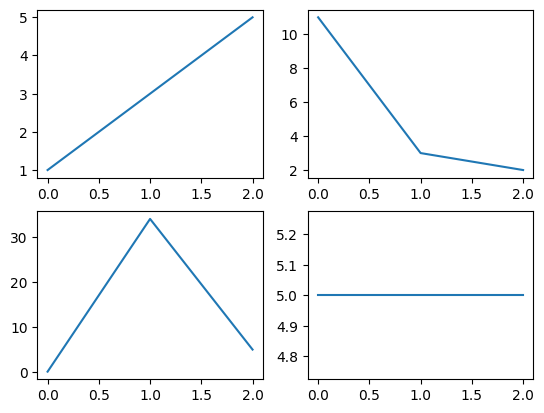

In [6]:
fig,axs = plt.subplots(nrows=2,ncols=2)
axs[0,0].plot([1,3,5])
axs[0,1].plot([11,3,2])
axs[1,0].plot([.1,34,5])
axs[1,1].plot([5,5,5])
plt.show()

In [114]:
def load_rat_comodulograms(day_id, rat_ids):
    '''
    make a dict with all comodulograms, indexed by keys with the following structure rat{rat_number}_day{day}_{session_moment} (moments being either early/late)
    '''

    base_file_location = f'/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/'

    all_comodulograms = {}

    for rat_id in rat_ids:
        # define file names for early and late comodulograms
        early_file_name = f"{base_file_location}rat{rat_id}_day{day_id}_LFP_all/NREM_comodulograms_before_training_rat{rat_id}-day{day_id}.npy"
        late_file_name = f"{base_file_location}rat{rat_id}_day{day_id}_LFP_all/NREM_comodulograms_after_training_rat{rat_id}-day{day_id}.npy"

        # load the comodulograms
        early_comodulogram = np.load(early_file_name)
        late_comodulogram = np.load(late_file_name)

        # store the loaded comodulograms in the dictionary with the specified keys
        all_comodulograms[f"rat{rat_id}_day{day_id}_early"] = early_comodulogram
        all_comodulograms[f"rat{rat_id}_day{day_id}_late"] = late_comodulogram

    return all_comodulograms

In [ ]:
def build_early_late_matrices(rats_list,early_late_permutation_statements=(False,False,False,False)):
  assert len(rats_list) == len(early_late_permutation_statements)
  '''this piece of code is absolutely atrocious but as Boltzmann once put it "Eleganz sei die Sache der Schuster und Schneider"; eventually i'll make it better'''

  #select from each rat's dictionary (early == True/late==False) according to the flipping rule (if True, then late-stage comodulogram will be stored in the early matrix and vice-versa for the early-stage)
  early = np.dstack([rats[i][key] for i,key in enumerate(early_late_permutation_statements)])
  late = np.dstack([rats[i][not key] for i,key in enumerate(early_late_permutation_statements)])

  stacked_matrix = np.nan_to_num(np.stack([early,late]))
  return stacked_matrix

In [133]:
def t_scores_from_conditions_matrix(early_late_matrix,adstringent=False):
  conditions,dep_freqs,ind_freqs,animals = np.shape(early_late_matrix)

  t_matrix = np.zeros(shape = [dep_freqs,ind_freqs])

  #for each point in the comodulogram surface compare data from condition 1 (early) to condition 2 (late)
  for i in range(dep_freqs):
    for j in range(ind_freqs):
      t_score = scipy.stats.ttest_rel(early_late_matrix[0,i,j,:],early_late_matrix[1,i,j,:]) #early - late
      if np.isnan(t_score[0]):
        continue
      else:
        if adstringent:
          if t_score[1] <= 0.05: #if the t-test for that frequency pair has an uncorrected p-score less than or equal to 0.05
            t_matrix[i,j] = t_score[0]
          else: #if the (uncorrected) p-value in that point in the comodulogram is not significant
            continue #keep the value at the point at 0 as was
        else: #here we relax the constraint a little. nonetheless we shall compare that to random permutations later (not a recommended pratice though)
          print(t_score[0])
          t_matrix[i,j] = t_score[0] #then we'll store its value

  return t_matrix

def otsu_binarize_t_scores_matrix(tscores_matrix):
  from skimage.filters import threshold_otsu

  tscores_otsu_threshold = threshold_otsu(abs(tscores_matrix))
  # initialize a matrix of same dimentions with values set to 0;
  thresholded = np.zeros_like(tscores_matrix)
  # if the absolute value of the t-score in a point sits above the otsu threshold
  # then assign 1 to this point
  for (coords,value) in np.ndenumerate(tscores_matrix):
    if (abs(value) > tscores_otsu_threshold):
      thresholded[coords] = 1
  return thresholded

def clusters_coordinates(binarized_matrix):
  #identify clusters in a binarized matrix and return a dictionary containing the following key-value pairs:
   #{cluster:[coordinates of all its constituent elements in the matrix]}

  from skimage import measure

  # identify clusters
  labeled_clusters = measure.label(binarized_matrix)
  # estimate cluster properties
  cluster_properties = measure.regionprops(labeled_clusters)

  # out of these properties, build a dictionary featuring the coordinates of points in each cluster, hashed by an integer id
  cluster_coordinates_dict = {cluster_id:cluster.coords for cluster_id,cluster in enumerate(cluster_properties)}

  return cluster_coordinates_dict

def mass_value_in_cluster(tscores_matrix,cluster_coordinates):
  # sum the t-scores from all points within a cluster
  mass_value = 0

  for (i,j) in cluster_coordinates:
    mass_value += tscores_matrix[i,j] # sum the t-value in each point in the cluster
  return mass_value

def set_cluster_points_to_value(tscores_matrix,cluster_coordinates,value):
  altered_matrix = tscores_matrix.copy()
  # set all points in a cluster to the same value (e.g. the mass value in the cluster, the corrected p-value, etc.)
  for (i,j) in cluster_coordinates:
    altered_matrix[i,j] = value

  return altered_matrix

def non_corrected_cluster_masses(tscores_matrix):
  '''given a tscores_matrix binarizes it, finds its clusters and the mass of each cluster, and finally assigns this mass to each element in it.
  The return is a matrix like the tscores_matrix but whose values are 0 for points
  that do not belong to any cluster and the clusters' mass for points within each cluster'''

  binarized = otsu_binarize_t_scores_matrix(tscores_matrix)
  coords_dict = clusters_coordinates(binarized)
  masses_dict = {cluster_id:mass_value_in_cluster(tscores_matrix,coords) for cluster_id,coords in coords_dict.items()}

  cluster_masses_matrix = binarized.copy()

  for cluster_id,coords in coords_dict.items():
    cluster_masses_matrix = set_cluster_points_to_value(cluster_masses_matrix,coords,masses_dict[cluster_id])

  return cluster_masses_matrix

def cluster_tscore_distribution(tscores_matrix):
  # distribution of mass values over identified clusters in a binarization of the (pointwise compared) t-scores matrix
  return [mass_value_in_cluster(tscores_matrix,coords) for coords in clusters_coordinates(otsu_binarize_t_scores_matrix(tscores_matrix)).values()]

def possible_permutations(num_rats):
  # permutatations of labels that can be either True or False for each rat.
  #e.g. with 3 rats: [True, True, True], [True, True, False], [True, False, True], ..., [False, False, False]
  import itertools
  possible_permutations = list(itertools.product([True, False], repeat=len(rats)))
  return possible_permutations

def permutated_extrema_distribution(rats_list,possible_permutations):
  permutated_extrema_distribution = []

  for realized_permutation in possible_permutations:
    # build a possible permutation from the observed comodulograms early/late in session (see build_early_late_matrices() above)
    permutated_matrix = build_early_late_matrices(rats_list = rats,early_late_permutation_statements = realized_permutation)

    # pointwise t-score this permutated matrix
    permutated_t_scores = t_scores_from_conditions_matrix(permutated_matrix)

    #find the distribution of mass over clusters in this pointwise t-scored matrix
    #current_permutation_extreme_cluster_mass = max(cluster_tscore_distribution(permutated_t_scores))
    perm_clusters_masses = cluster_tscore_distribution(permutated_t_scores)
    #the most extreme value is either the least or the maximum of the cluster masses; select the greatest between their absolute values
    current_permutation_extreme_cluster_mass = max(min(perm_clusters_masses), max(perm_clusters_masses), key=abs)
    #save it
    permutated_extrema_distribution.append(current_permutation_extreme_cluster_mass)

  return permutated_extrema_distribution

def correct_clusters_pscores(tscores_matrix,permutations_distribution):
  # initialize a matrix with the same dimensions as the comodulograms but filled with ones; corrected p-values for identified clusters will substitute ones in each cluster's coordinates
  corrected_tscores_matrix = np.ones_like(tscores_matrix)
  identified_clusters = clusters_coordinates(otsu_binarize_t_scores_matrix(tscores_matrix))

  for cluster_id,coordinates in identified_clusters.items():
    cluster_mass = abs(mass_value_in_cluster(t_scores_matrix,coordinates))
    '''
    A cluster's p-value is the proportion of permutations whose maximum t-score is larger than the t-scored observed in this cluster (from the original data)
    See: doi:10.1016/j.jneumeth.2007.03.024 (section 2.3, step 5)
    '''
    cluster_p_value = len(np.argwhere(np.abs(permutations_distribution) > abs(cluster_mass)))/len(permutations_distribution)
    print(cluster_p_value)
    corrected_tscores_matrix = set_cluster_points_to_value(corrected_tscores_matrix,coordinates,cluster_p_value) # set all points in this cluster to its corrected p-value
  return corrected_tscores_matrix

def cluster_analysis_pipeline_panel(rats_list,adstringency=False):
  #rats list is a list of dicts in which each entry is a {True:comod_matrix_early,False:comod_matrix_late}
  observations = build_early_late_matrices(rats_list)

  # matrix of t-scores for each point in the comodulogram across conditions (early/late); every point in the comodulogram (i.e. a freq. pair) has 4 exemplars (1 from each rat) per condition
  t_scores_matrix = t_scores_from_conditions_matrix(observations)

  # binarize the scores such that non-cluster values are set to 0 and clusters to 1
  otsu_binarized_scores = otsu_binarize_t_scores_matrix(t_scores_matrix)

  permutations_list = possible_permutations(len(rats_list))
  permutations_list.pop(-1) # the last permutation is the original data: [False, False, False, False], so no rat's data get permutated at all
  permutations_extreme_masses_distribution = permutated_extrema_distribution(rats_list,permutations_list)

  cluster_pvals = correct_clusters_pscores(t_scores_matrix,permutations_extreme_masses_distribution)

  return {'t_scores_matrix':t_scores_matrix,'binarized':otsu_binarized_scores,
          'non_corrected_clusters':non_corrected_cluster_masses(t_scores_matrix),'corrected_clusters':cluster_pvals,
          'permutations_masses_dist':permutations_extreme_masses_distribution,'num_perms':len(permutations_list)}

  #returns: t-scores matrix, binarized, clusters t-mass (not corrected), clusters p-values (corrected), number of permutations

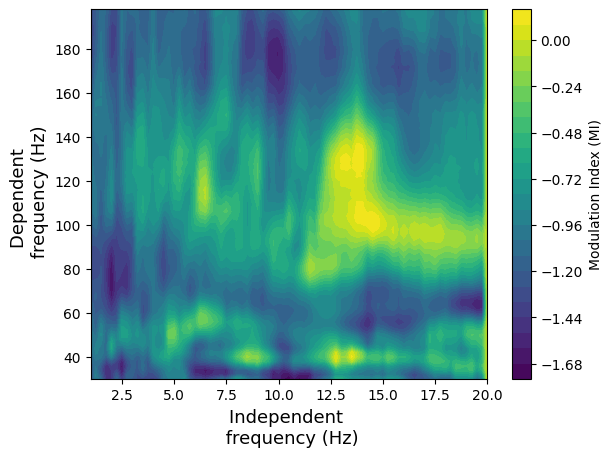

In [90]:
plot_sleep_comodulogram(test['t_scores_matrix'])

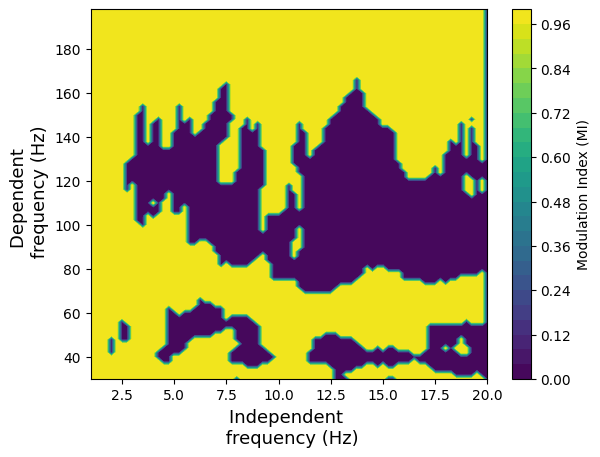

In [92]:
plot_sleep_comodulogram(test['binarized'])

In [117]:
all_comodulograms_day1.keys()

dict_keys(['rat3_day1_early', 'rat3_day1_late', 'rat4_day1_early', 'rat4_day1_late', 'rat5_day1_early', 'rat5_day1_late', 'rat6_day1_early', 'rat6_day1_late'])

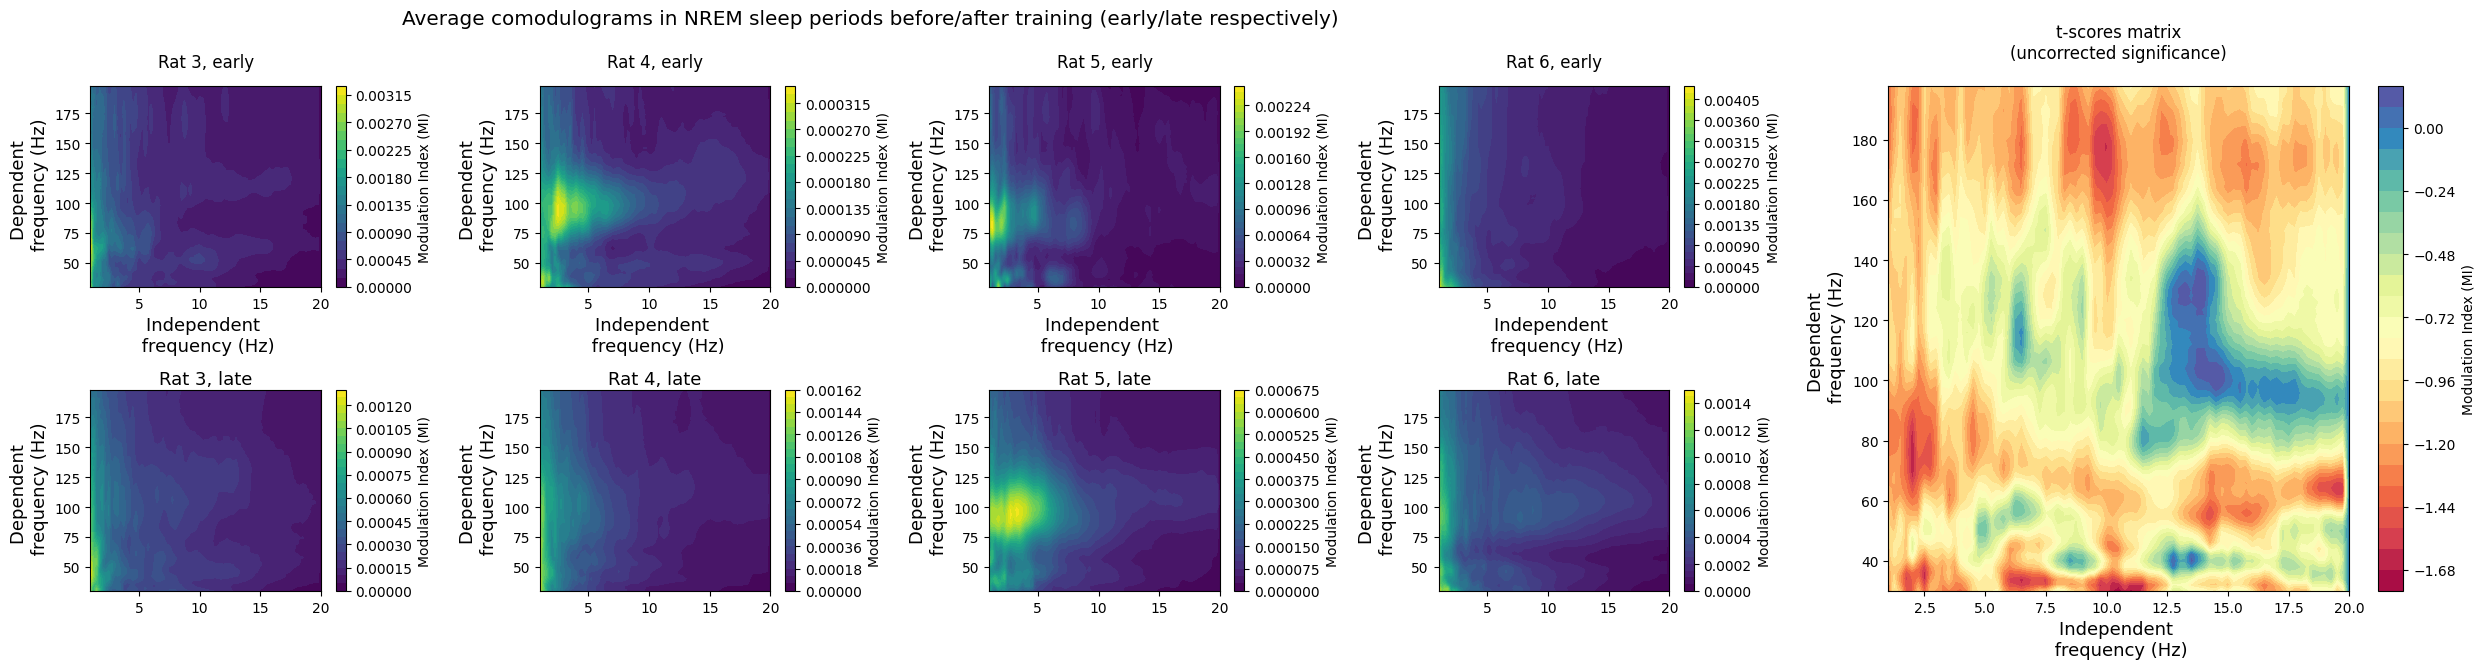

In [163]:
def plot_sleep_comodulogram(comod, ax=None,colormap='viridis',modulation_index_cbar=True):
    freqs_for_amps = np.arange(30, 202, 2)
    freqs_for_phases = np.arange(1, 20.25, .25)

    # make a grid to accommodate the data
    x, y = np.meshgrid(freqs_for_phases, freqs_for_amps[:-1])

    # if no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    contour = ax.contourf(x, y, comod, 30, cmap=colormap)
    ax.set_xlabel('Independent \n frequency (Hz)', size=13)
    ax.set_ylabel('Dependent \n frequency (Hz)', size=13)
    if modulation_index_cbar:
      cbar = plt.colorbar(contour, ax=ax, label="Modulation Index (MI)")

    return ax

day_id = 1
rat_ids = [3,4,5,6]
conditions = ['early','late']
#conditions = ['day1','day2'] # in case you want to compare consecutive days instead of session parts

all_comodulograms = load_rat_comodulograms(day_id,rat_ids)
average_comodulograms = {key:np.nanmean(comodulogram,axis=0) for key,comodulogram in all_comodulograms.items()}

import matplotlib.gridspec as gridspec

# Create a figure with specific size to accommodate the layout
fig = plt.figure(figsize=(25, 7))

# Create a GridSpec with 2 rows and 5 columns
# The last column is for the bigger subplot, so it takes twice the width_ratio
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 2], height_ratios=[1, 1])

# Create subplots in the first 4 columns (2 rows x 4 columns)
for i,condition in enumerate(conditions):
    for j,current_rat in enumerate(rat_ids):
        ax = fig.add_subplot(gs[i, j])
        #ax.set_aspect('equal', adjustable='box')  # Making the subplot square
        # Example plotting in the small subplot
        plot_sleep_comodulogram(average_comodulograms[f'rat{current_rat}_day{day_id}_{condition}'],ax)  # Replace with actual plotting code if needed

        # Set titles for the top row
        if i == 0:
            ax.set_title(f'Rat {current_rat}, {condition}', y=1.05)

        # Set captions for the bottom row
        if i == 1:
            ax.set_xlabel(f'Rat {current_rat}, {condition}')
            ax.xaxis.set_label_position('top')

# bigger subplot in the last column, spanning both rows
ax_big = fig.add_subplot(gs[:, 4])

plot_sleep_comodulogram(test['t_scores_matrix'], ax=ax_big,colormap='Spectral',modulation_index_cbar=True)

# set a separate title for the bigger axis
ax_big.set_title('t-scores matrix\n(uncorrected significance)', pad=20)

# set a suptitle horizontally centered over the left 4 columns of smaller plots, which acts like a title for the left comodulograms
fig.suptitle('Average comodulograms in NREM sleep periods before/after training (early/late respectively)', x=0.35, y=0.95, fontsize='x-large', ha='center')

plt.tight_layout()
plt.show()

In [166]:
average_comodulograms.keys()

dict_keys(['rat3_day1_early', 'rat3_day1_late', 'rat4_day1_early', 'rat4_day1_late', 'rat5_day1_early', 'rat5_day1_late', 'rat6_day1_early', 'rat6_day1_late'])

In [ ]:
def permutate_conditions(flip_tuple, data_dict):
    """
    Flips the condition matrices for specified rats within the data dictionary.

    Parameters:
    flip_tuple (tuple): A tuple of Boolean values where each value corresponds to a rat.
                        True indicates that the rat's conditions should be permutated (e.g. early -> late and vice versa or day 1 -> day 2 and vice versa).
    data_dict (dict): A dictionary containing the rats' data for each condition.

    Returns:
    dict: A new dictionary with the specified rats' conditions swapped.
    """

    # ensure the flip tuple is the correct length
    num_rats = len(flip_tuple)
    if num_rats != len(data_dict) // 2:
        raise ValueError("Length of flip_tuple must match half the number of keys in data_dict")

    # create a new dictionary to store the flipped data
    new_data_dict = {}

    # iterate over each rat and condition in the original dictionary
    for rat_id in range(1, num_rats + 1):
        # define keys for condition 1 and condition 2
        key_cond1 = f'rat{rat_id}_cond1'
        key_cond2 = f'rat{rat_id}_cond2'

        # check if the current rat's conditions should be flipped
        if flip_tuple[rat_id - 1]:  # Adjusting for zero-indexing
            # swap the conditions
            new_data_dict[key_cond1] = data_dict[key_cond2]
            new_data_dict[key_cond2] = data_dict[key_cond1]
        else:
            # keep the conditions as they are
            new_data_dict[key_cond1] = data_dict[key_cond1]
            new_data_dict[key_cond2] = data_dict[key_cond2]

    return new_data_dict

In [172]:
def paired_t_test_over_conditions(data_dict):
    # Assume data_dict is like {'rat1_cond1': matrix, 'rat1_cond2': matrix, ..., 'ratN_cond2': matrix}
    # Extract matrix dimensions from the first entry
    matrix_shape = next(iter(data_dict.values())).shape

    # Initialize the t-score matrix
    t_score_matrix = np.zeros(matrix_shape)

    # Iterate over each matrix element
    for i in range(matrix_shape[0]):
        for j in range(matrix_shape[1]):
            # Extract the data for this element across all animals and conditions
            cond1_data = [data_dict[f'rat{rat_id}_day1_early'][i, j] for rat_id in range(3, 7)]
            cond2_data = [data_dict[f'rat{rat_id}_day1_late'][i, j] for rat_id in range(3, 7)]

            # Perform the paired t-test
            t_stat, p_val = scipy.stats.ttest_rel(cond1_data, cond2_data)

            if np.isnan(t_stat):
              continue
            else:
              # store the t-score
              t_score_matrix[i, j] = t_stat

    # Return the matrix of t-scores
    return t_score_matrix

# Example usage:
# Assuming data_dict has been defined and populated with your data
t_scores = paired_t_test_over_conditions(average_comodulograms)

<Axes: xlabel='Independent \n frequency (Hz)', ylabel='Dependent \n frequency (Hz)'>

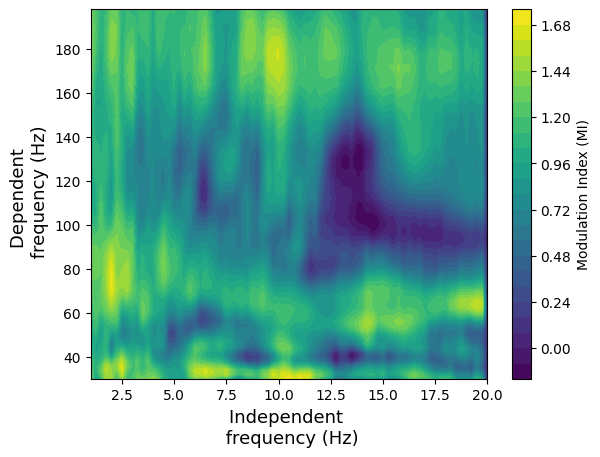

In [173]:
plot_sleep_comodulogram(t_scores)

In [164]:
for position,_ in np.ndenumerate(average_comodulograms[f'rat{3}_day1_early']):
  earliess = []
  latsss = []
  for rat in [3,4,5,6]:
    earliess.append(average_comodulograms[f'rat{rat}_day1_early'][position])
    latsss.append(average_comodulograms[f'rat{rat}_day1_late'][position])
  if ((scipy.stats.ttest_rel(earliess,latsss)[0])>=1 and (not np.isnan(scipy.stats.ttest_rel(earliess,latsss)[0]))):
    print(scipy.stats.ttest_rel(earliess,latsss)[0])
#print(earliess,f'\n{latsss}')


1.3378374019173798
1.1132861411658383
1.496499127887123
1.4383296585596002
1.1433205404417686
1.4348232230457008
1.1675140129430082
1.2223441382736357
1.2955733016935713
1.3066343092466657
1.3630520969283224
1.39965103153784
1.2935785957290222
1.0387630950458384
1.2157508737692324
1.3615835826627691
1.339416578836597
1.404798841056604
1.3223629434184776
1.2485380187926596
1.1026299089917033
1.1392690492148947
1.0817729896887993
1.0616438330370723
1.2462573580715213
1.3489398927583875
1.5775367001167786
1.5476919320138667
1.6808389403067996
1.7463986129167461
1.6129392829124138
1.7172044344344817
1.6316117733050188
1.5859908981797117
1.2962155554313908
1.1926876577623393
1.0357155549308839
1.1668697715271654
1.2873414805221393
1.237745139441625
1.2042920902166672
1.1470571327748198
1.0337309028769728
1.1454655468586257
1.1354774644471883
1.107398709124389
1.0646925650535928
1.3137222399626873
1.2334472772168645
1.5088340175689317
1.4486019677149446
1.2287612922923032
1.5448500039695483


KeyboardInterrupt: 

<Axes: >

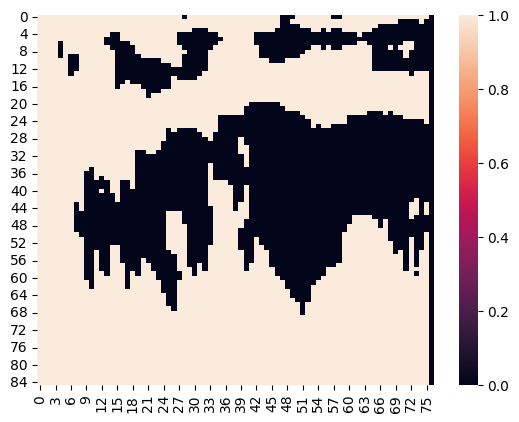

In [91]:
sns.heatmap(test['binarized'])

In [116]:
import numpy as np



# Example usage:
day_id = 1
rat_ids = [3, 4, 5,6] # Replace with actual rat IDs
all_comodulograms_day1 = load_rat_comodulograms(day_id, rat_ids)

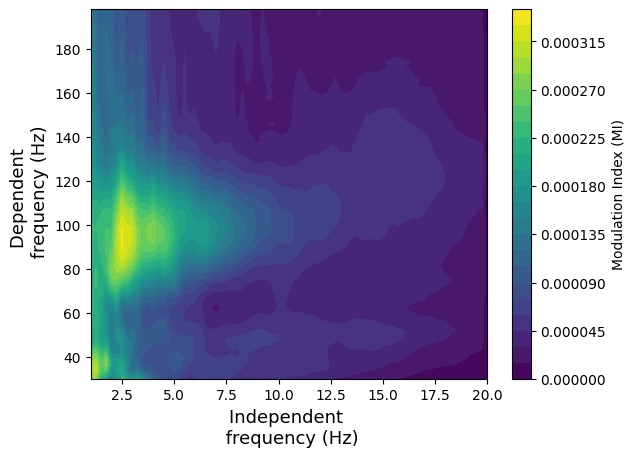

In [111]:
plot_sleep_comodulogram(np.nanmean(all_comodulograms['rat4_day1_early'],axis=0))

In [8]:
#These are the frequencies over which we will build the comodulogram; for now I am making them fixed but later they will be incorporated as parameters

def plot_sleep_comodulogram(comod):

  freqs_for_amps = np.arange(30,202,2)
  freqs_for_phases = np.arange(1,20.25,.25)

  #make a grid to accommodate the data
  x,y = np.meshgrid(freqs_for_phases,freqs_for_amps[:-1])

  plt.contourf(x, y, comod, 30, cmap=plt.cm.viridis)
  plt.xlabel('Independent \n frequency (Hz)',size=13)
  plt.ylabel('Dependent \n frequency (Hz)',size=13)
  plt.colorbar(label="Modulation Index (MI)")

In [104]:
def pre_and_post_NREM_comodulograms(rat_id,day_id,average=True):
  file_location = f'/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat{rat_id}_day{day_id}_LFP_all/'

  pre_session_comods = np.load(f'{file_location}/NREM_comodulograms_before_training_rat{rat_id}-day{day_id}.npy')
  post_session_comods = np.load(f'{file_location}/NREM_comodulograms_after_training_rat{rat_id}-day{day_id}.npy')

  if average:
    return {True:np.nanmean(pre_session_comods,axis=0),False:np.nanmean(post_session_comods,axis=0)}
  else:
    return {'Early':pre_session_comods,'Late':post_session_comods}

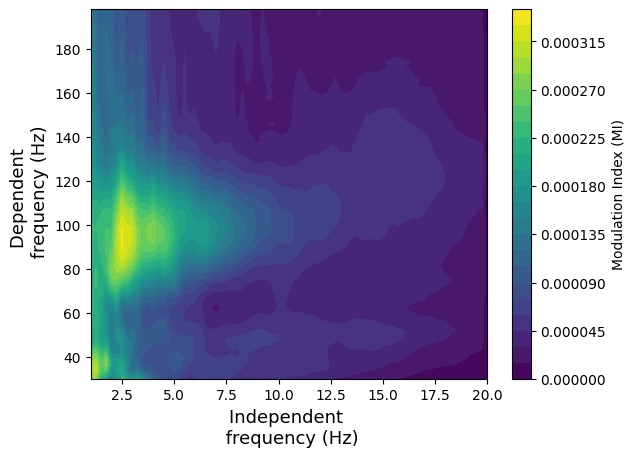

In [113]:
teste_rat3_day1 = pre_and_post_NREM_comodulograms(4,1,average=False)
plot_sleep_comodulogram(np.nanmean(teste_rat3_day1['Early'],axis=0))
#plot_sleep_comodulogram(np.nanmean(teste_rat3_day1['Late'],axis=0))

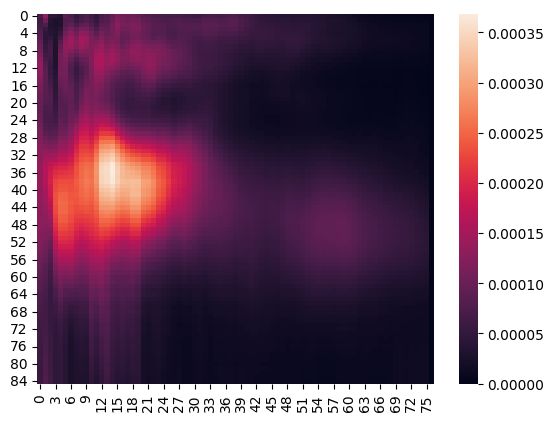

<Axes: >

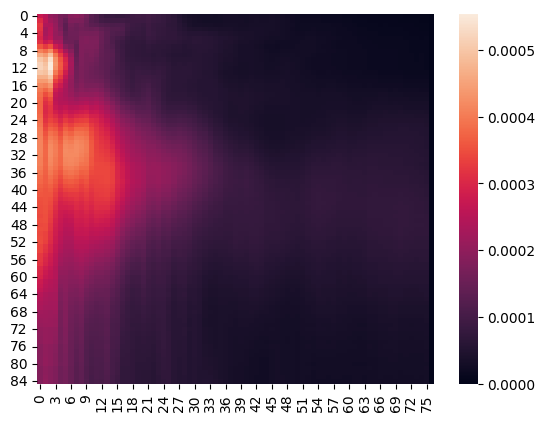

In [11]:
teste_rat3_day1 = pre_and_post_NREM_comodulograms(4,2)
sns.heatmap(teste_rat3_day1[True])
plt.show()
sns.heatmap(teste_rat3_day1[False])

'''
PASSOS PRA AMANHÃ:
1. identificar clusters a partir dessa t_scores_matrix (FEITO)
2. descobrir se consigo pegar quais pontos de uma matriz pertencem a cada cluster (ideal)  (FEITO)
3. somar os valores dentro de cada cluster pra obter um _valor de massa do cluster_ (FEITO)
4. descobrir se consigo atribuir o _valor de massa_ a todos seus valores num cluster rotulado (FEITO)
4. implementar as permutações (DONE)
5. pegar o valor máximo entre as somas de todos clusters rotulados em uma comparação de comodulogramas (DONE)
6. fazer 123091283 permutações (ver se eu não consigo fazer o número máximo? acho que consigo sim!) e salvar o valor mais alto de cada uma numa lista (distribuição de t-scores extremos) (DONE)
7. p-value de cada cluster = ranking do valor de massa dele (percentil ocupado?) na distribuição de t-scores extremos (DONE)
8. todos elementos do cluster são tingidos com o mesmo p-value; demais pontos no gráfico têm p-value = 1 (DONE)
'''

In [82]:
#example with day 2
rats = []
for rat_id in range(3,7):
  os.chdir(f'/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels/data/separated_channels/rat{rat_id}_day1_LFP_all/')

  pre_session_comods = np.load(f'./NREM_comodulograms_before_training_rat{rat_id}-day1.npy')
  post_session_comods = np.load(f'./NREM_comodulograms_after_training_rat{rat_id}-day1.npy')

  rats.append({True:np.mean(pre_session_comods,axis=0),False:np.mean(post_session_comods,axis=0)})

In [15]:
def build_early_late_matrices(rats_list,early_late_permutation_statements=(False,False,False,False)):
  assert len(rats_list) == len(early_late_permutation_statements)
  '''this piece of code is absolutely atrocious but as Boltzmann once put it "Eleganz sei die Sache der Schuster und Schneider"; eventually i'll make it better'''

  #select from each rat's dictionary (early == True/late==False) according to the flipping rule (if True, then late-stage comodulogram will be stored in the early matrix and vice-versa for the early-stage)
  early = np.dstack([rats[i][key] for i,key in enumerate(early_late_permutation_statements)])
  late = np.dstack([rats[i][not key] for i,key in enumerate(early_late_permutation_statements)])

  stacked_matrix = np.nan_to_num(np.stack([early,late]))
  return stacked_matrix

#rat1 = {True:example_dict['trial_3'], False:example_dict['trial_693']}
#rat2 = {True:example_dict['trial_9'], False:example_dict['trial_688']}
#rat3 = {True:example_dict['trial_10'], False:example_dict['trial_696']}
#rat4 = {True:example_dict['trial_12'], False:example_dict['trial_694']}

#rats = [rat1,rat2,rat3,rat4]

import itertools
possible_permutations = list(itertools.product([True, False], repeat=len(rats)))

In [16]:
observed_early_late = build_early_late_matrices(rats)

In [17]:
np.shape(observed_early_late)

(2, 85, 77, 4)

<Axes: >

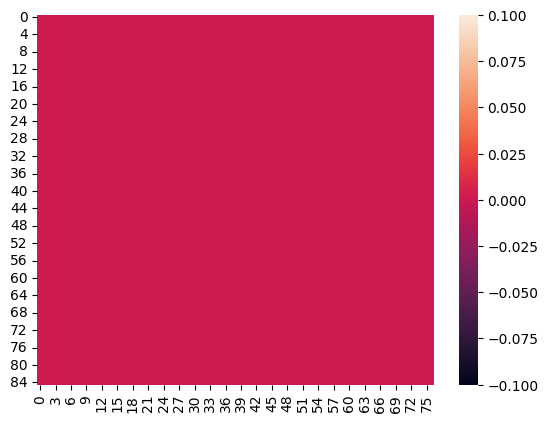

In [24]:
# matrix of t-scores for each point in the comodulogram across conditions (early/late); every point in the comodulogram (i.e. a freq. pair) has 4 exemplars (1 from each rat) per condition
t_scores_matrix = np.zeros(shape = (np.shape(observed_early_late)[1],np.shape(observed_early_late)[2]))
sns.heatmap(t_scores_matrix)

In [25]:
def t_scores_from_conditions_matrix(early_late_matrix):
  conditions,dep_freqs,ind_freqs,animals = np.shape(early_late_matrix)

  t_matrix = np.zeros(shape = [dep_freqs,ind_freqs])

  #for each point in the comodulogram surface compare data from condition 1 (early) to condition 2 (late)
  for i in range(dep_freqs):
    for j in range(ind_freqs):
      t_score = scipy.stats.ttest_rel(early_late_matrix[0,i,j,:],early_late_matrix[1,i,j,:]) #early - late
      if np.isnan(t_score[0]):
        continue
      else:
        #print(t_score[1])
        #if t_score[1] <= 0.05: #if the t-test for that frequency pair has an uncorrected p-score less than or equal to 0.05
        t_matrix[i,j] = t_score[0] #then we'll store its value

  return t_matrix

early
late


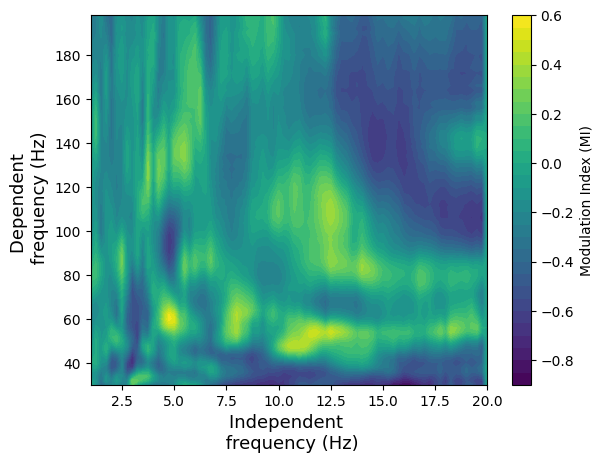

In [27]:
t_scores_matrix = t_scores_from_conditions_matrix(observed_early_late)#,adstringent=False)
#sns.heatmap(t_scores_matrix,cmap='viridis')
plot_sleep_comodulogram(t_scores_matrix)
#plt.show()
print('early')
#plot_sleep_comodulogram(np.mean(observed_early_late,axis=3)[0,:,:])
#plt.show()
print('late')
#plot_sleep_comodulogram(np.mean(observed_early_late,axis=3)[1,:,:])

In [28]:
def otsu_binarize_t_scores_matrix(tscores_matrix):
  from skimage.filters import threshold_otsu

  tscores_otsu_threshold = threshold_otsu(abs(tscores_matrix))
  # initialize a matrix of same dimentions with values set to 0;
  thresholded = np.zeros_like(tscores_matrix)
  # if the absolute value of the t-score in a point sits above the otsu threshold
  # then assign 1 to this point
  for (coords,value) in np.ndenumerate(tscores_matrix):
    if (abs(value) > tscores_otsu_threshold):
      thresholded[coords] = 1
  return thresholded

In [65]:
# soon to be deprecated
#def binarize_t_scores_matrix(tscores_matrix):
#  # initialize all values to 1; if the absolute value of an element is close to zero (remember the t-scores matrix was initialized with np.zeros()) then assign 0 to it
#  binarized_matrix = np.ones_like(tscores_matrix)
#  for (coords,value) in np.ndenumerate(tscores_matrix):
#    if np.isclose(abs(value),0):
#      binarized_matrix[coords] = 0
#  return binarized_matrix

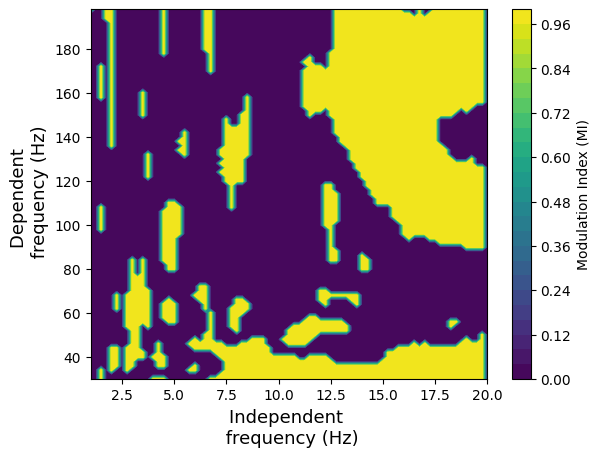

In [29]:
testando_binary = otsu_binarize_t_scores_matrix(t_scores_matrix)
#sns.heatmap(testando_binary)
plot_sleep_comodulogram(testando_binary)

In [30]:
def clusters_coordinates(binarized_matrix):
  #identify clusters in a binarized matrix and return a dictionary containing the following key-value pairs:
   #{cluster:[coordinates of all its constituent elements in the matrix]}

  from skimage import measure

  # identify clusters
  labeled_clusters = measure.label(binarized_matrix)
  # estimate cluster properties
  cluster_properties = measure.regionprops(labeled_clusters)

  # out of these properties, build a dictionary featuring the coordinates of points in each cluster, hashed by an integer id
  cluster_coordinates_dict = {cluster_id:cluster.coords for cluster_id,cluster in enumerate(cluster_properties)}

  return cluster_coordinates_dict

In [31]:
clusters_test = clusters_coordinates(testando_binary)

In [32]:
clusters_test

{0: array([[0, 2],
        [1, 2],
        [2, 2]]),
 1: array([[ 0, 12],
        [ 0, 13],
        [ 0, 14]]),
 2: array([[ 0, 23],
        [ 0, 24],
        [ 0, 25],
        [ 0, 26],
        [ 0, 27],
        [ 0, 28],
        [ 0, 29],
        [ 0, 30],
        [ 0, 31],
        [ 0, 32],
        [ 0, 33],
        [ 0, 34],
        [ 0, 35],
        [ 0, 36],
        [ 0, 37],
        [ 0, 38],
        [ 0, 39],
        [ 0, 40],
        [ 0, 41],
        [ 0, 42],
        [ 0, 43],
        [ 0, 44],
        [ 0, 45],
        [ 0, 46],
        [ 0, 47],
        [ 0, 48],
        [ 0, 49],
        [ 0, 50],
        [ 0, 51],
        [ 0, 52],
        [ 0, 53],
        [ 0, 54],
        [ 0, 55],
        [ 0, 56],
        [ 0, 57],
        [ 0, 58],
        [ 0, 59],
        [ 0, 60],
        [ 0, 61],
        [ 0, 62],
        [ 0, 63],
        [ 0, 64],
        [ 0, 65],
        [ 0, 66],
        [ 0, 67],
        [ 0, 68],
        [ 0, 69],
        [ 0, 70],
        [ 0, 71],
   

In [175]:
cluster_tscore_distribution(t_scores_matrix)

[-1.062260774022063,
 -0.9258293985263467,
 -186.66804216639483,
 -4.507491158782532,
 -37.977216567502175,
 -0.8978488114372689,
 -3.5696439593311333,
 18.771538546486315,
 6.448597215136588,
 0.954537612752492,
 6.503824497439392,
 -1.3104877543801519,
 -4.992550605466725,
 -23.813814077305825,
 2.268619676483706,
 12.545288025321419,
 -634.1844015109176,
 -1.8853479403194497,
 -26.1182341384942,
 1.8507000650977679,
 2.48007017263608,
 -11.808685550548043,
 -1.7834141440731188,
 -2.4379926439799484,
 -9.23999071603583,
 -3.323700537869856,
 -0.2936842120911015]

In [176]:
def mass_value_in_cluster(tscores_matrix,cluster_coordinates):
  # sum the t-scores from all points within a cluster
  mass_value = 0

  for (i,j) in cluster_coordinates:
    mass_value += tscores_matrix[i,j] # sum the t-value in each point in the cluster
  return mass_value

# uncomment for a demonstration
mass_value_in_cluster(t_scores_matrix,clusters_test[0])

-1.062260774022063

In [177]:
def set_cluster_points_to_value(tscores_matrix,cluster_coordinates,value):
  altered_matrix = tscores_matrix.copy()
  # set all points in a cluster to the same value (e.g. the mass value in the cluster, the corrected p-value, etc.)
  for (i,j) in cluster_coordinates:
    altered_matrix[i,j] = value

  return altered_matrix

In [178]:
def cluster_tscore_distribution(tscores_matrix):
  # distribution of mass values over identified clusters in the binarized (pointwise compared) t-scores matrix
  return [mass_value_in_cluster(tscores_matrix,coords) for coords in clusters_coordinates(otsu_binarize_t_scores_matrix(tscores_matrix)).values()]
  #return [mass_value_in_cluster(tscores_matrix,coords) for coords in clusters_coordinates(binarize_t_scores_matrix(tscores_matrix)).values()]

In [179]:
permutated_extrema_distribution = []

for realized_permutation in possible_permutations:
  # build a possible permutation from the observed comodulograms early/late in session (see build_early_late_matrices() above)
  permutated_matrix = build_early_late_matrices(rats_list = rats,early_late_permutation_statements = realized_permutation)

  # pointwise t-score this permutated matrix
  permutated_t_scores = t_scores_from_conditions_matrix(permutated_matrix)

  #find the distribution of mass over clusters in this pointwise t-scored matrix
  #current_permutation_extreme_cluster_mass = max(cluster_tscore_distribution(permutated_t_scores))
  perm_clusters_masses = cluster_tscore_distribution(permutated_t_scores)
  #the most extreme value is either the least or the maximum of the cluster masses; select the greatest between their absolute values
  current_permutation_extreme_cluster_mass = max(min(perm_clusters_masses), max(perm_clusters_masses), key=abs)
  #save it
  permutated_extrema_distribution.append(current_permutation_extreme_cluster_mass)

permutated_extrema_distribution

[634.1844015109176,
 1662.9147906141957,
 372.23130263908524,
 3093.418854860888,
 942.1204072535244,
 1745.9261288703904,
 627.1946357418341,
 5861.348667760966,
 -5861.348667760966,
 -627.1946357418341,
 -1745.9261288703904,
 -942.1204072535244,
 -3093.418854860888,
 -372.23130263908524,
 -1662.9147906141957,
 -634.1844015109176]

In [180]:
# initialize a matrix with the same dimensions as the comodulograms but filled with ones; corrected p-values for identified clusters will substitute ones in each cluster's coordinates
corrected_tscores_matrix = np.ones_like(t_scores_matrix)

for cluster_id,coordinates in clusters_test.items():
  cluster_mass = abs(mass_value_in_cluster(t_scores_matrix,coordinates))
  #print(cluster_mass)
  '''
  A cluster's p-value is the proportion of permutations whose maximum t-score is larger than the t-scored observed in this cluster (from the original data)
  See: doi:10.1016/j.jneumeth.2007.03.024 (section 2.3, step 5)
  '''
  cluster_p_value = len(np.argwhere(np.abs(permutated_extrema_distribution) > abs(cluster_mass)))/len(permutated_extrema_distribution)
  print(cluster_p_value)
  corrected_tscores_matrix = set_cluster_points_to_value(corrected_tscores_matrix,coordinates,cluster_p_value) # set all points in this cluster to its corrected p-value

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.625
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


<Axes: >

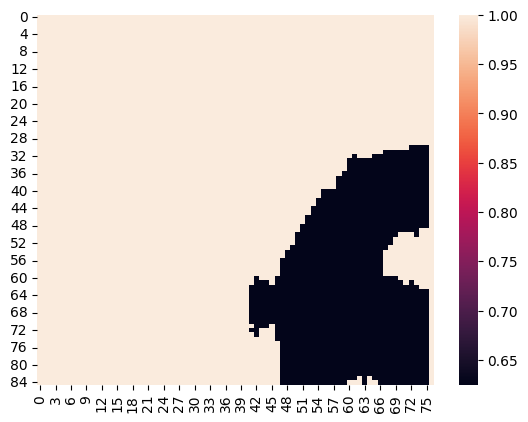

In [181]:
sns.heatmap(corrected_tscores_matrix)

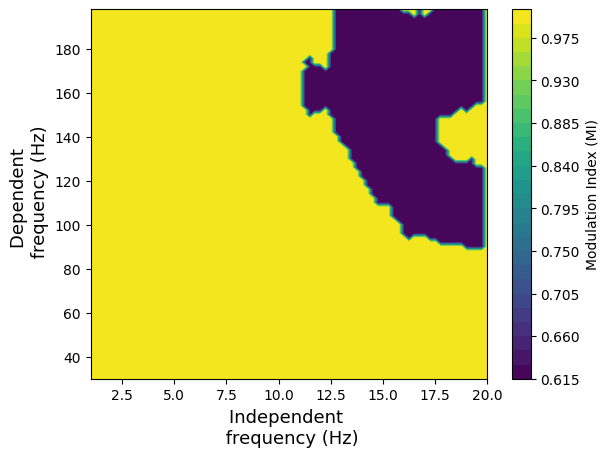

In [182]:
plot_sleep_comodulogram(corrected_tscores_matrix)